In [1]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, relu_, conv1d
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from sklearn.linear_model import LinearRegression

from htmresearch.frameworks.cans.utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.012

def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.00
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)

def w_1(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return -1*np.exp(-beta * x)


# Random walk builder
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False):
    trajectory = np.zeros((int(length), 2))
    x = np.random.rand()
    y = np.random.rand()
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = (((np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if 0 < (movement[0] + x) < 1 and 0 < (movement[1] + y) < 1 or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                break

    return(trajectory)

In [83]:
class GCN1D(object):
    
    def __init__(self,
                 numX,
                 inhibitionWindow,
                 inhibitionRadius,                 
                 inhibitionStrength,
                 boostEffect=10,
                 boostDecay=3.,
                 dt=0.001,
                 numPlaces=200,
                 globalTonic=20,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactor=.9,
                 initialWeightFactor=.2,
                 weightDecay=60,
                 boostGradientX=1,
                 wideningFactor=0,
                 gradientType="linear",
                 envSize=1,
                ):
        self.activity = torch.zeros([1., 1., numX], device=device, dtype=torch.float)
        self.filter = torch.zeros([1, 1, 1+2*inhibitionWindow], dtype=torch.float,
                                 device=device)
        self.numX = numX
        self.numPlaces=numPlaces
        
        for i in range(1+2*inhibitionWindow):
                xDist = np.abs(i - (inhibitionWindow))
                dist = max(xDist - wideningFactor, 0)**2
                if dist <= 0:
                    weight = 0
                else:
                    weight = w_1(dist/inhibitionRadius)*inhibitionStrength
                self.filter[0, 0, i] = weight
                
        self.activationHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        
        if "linear" in gradientType.lower():
            gradient = np.linspace(1, boostGradientX, numX)*boostEffect
        elif "exponential" in gradientType.lower():
            base = np.power(boostGradientX, 1./numX)
            gradient = np.power(base, np.arange(0, numX))
            
        self.boostEffect = torch.tensor(
            gradient*boostEffect, device=device, dtype=torch.float)
        
        self.boostDecay = boostDecay
        self.dt = dt
        self.globalTonic = torch.tensor([globalTonic], device=device, dtype=torch.float)
        self.decay = decayConstant
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = 0.01
        self.learningRate = learningRate
        self.negativeLearnFactor = negativeLearnFactor
        self.weightDecay = weightDecay
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.linspace(0, envSize, numPlaces), device=device, dtype=torch.float)
        self.envSize = envSize
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numPlaces)*initialWeightFactor,
                                         device=device, dtype=torch.float)
        
        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """

        envelopeX = [1 if self.numX/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numX/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numX) - self.numX/2.]


        return np.asarray(envelopeX)
    
    def step(self, speed=1, place=True): 
        if place:
            self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX)
        else:
            self.instantaneous.fill_(0.)
        self.instantaneous += conv1d(self.activity, self.filter, padding=self.inhibitionWindow)
        self.instantaneous += self.globalTonic
        self.instantaneous *= self.envelope
        self.instantaneous += self.activationHistory * self.boostEffect
        self.instantaneous *= min(speed, 1)
        relu_(self.instantaneous)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        #torch.min(self.activity, self.zero + 1., out=self.activity)
        self.activationHistory += (torch.sum(self.activity)/torch.sum(self.envelope) - self.activity)*self.dt*self.envelope
        #self.activationHistory -= self.dt*self.activationHistory/self.boostDecay
        
        
    def simulate(self, time, logFreq = 10, startFrom = 0):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                 dtype=torch.float)
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        
        s = 0
        for t in range(numSteps):
            self.step(place=False)
            if t % logFreq == 0 and t*self.dt >= startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX))
                s += 1
                
        return output.cpu().numpy()
    
    def decayWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*self.placeWeights/self.weightDecay
    
    def learn(self, runs, plotting=True, plotInterval=100, runLength = 10, offsets=(0,0), randomSpeed=True):
        if plotting:
                fig, (ax1, ax2, ax3) = plt.subplots(3,1)
                ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.learningRate*self.dt
        self.bufferIndex = 0
        
        # Space the starting points of the runs out.  This tends to improve the
        # translation-invariance of the weight profiles, and thus gives better
        # overall path integration.
        startingPoint = 0
        trajectories = []
        timings = []
        time = 0
        residTime = 0
        for run in xrange(runs):
            if randomSpeed:
                speed = np.random.random() + 0.5
            else:
                speed = 1.
            length = 10.*self.envSize / speed

            runTimes = np.arange(0, length, self.dt)
            trajectory = (np.sin((runTimes * np.pi / (5*self.envSize / speed) - np.pi / 2.)) + 1) * \
                         2.5*self.envSize + startingPoint
            trajectories.append(trajectory)
            timings.append(runTimes + time)
            time += length
            startingPoint += 1. / runs
        
        for trajectory, times in zip(trajectories, timings):
            self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                         dtype=torch.float)
            self.activationHistory.fill_(0.)
            self.bufferIndex = 0
            velocity = np.diff(trajectory)/self.dt
            trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
            velocity = torch.tensor(velocity, device=device, dtype=torch.float)
            speed = torch.abs(velocity)
            distances = torch.zeros((self.numPlaces, 2), device=device, dtype=torch.float)

            for i, t in enumerate(times[:-1]):
                pos = trajectory[i] % self.envSize
                s = min(speed[i]/torch.mean(speed), 1.)**5
                distances = torch.min(torch.abs(self.places - pos), torch.abs(1 - self.places + pos))
                torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
                self.placeActivity *= s
                self.step(speed=s)
                self.stdpUpdate(i)
                torch.max(self.placeWeights, self.zero, out=self.placeWeights)
                torch.min(self.placeWeights, self.zero + 2., out=self.placeWeights)
                #self.placeWeights *= .667/torch.mean(self.placeWeights, -1, keepdim=True)
                #self.decayWeights()
                if i % plotInterval == 0:
                    if plotting:
                        ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                        ax2.clear()
                        ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                        ax3.clear()
                        ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                        ax1.set_title(str(t))
                        fig.canvas.draw()

                
    def stdpUpdate(self, time, clearBuffer=False):
        if time < self.activityBuffer.shape[0]:
            self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                self.placeWeights += torch.ger(self.activity.view(self.numX), self.placeBuffer[i]* \
                                        self.stdpValues[t]).view(self.numX, self.numPlaces)
                self.placeWeights -= (torch.ger(self.activityBuffer[i], self.placeActivity) *\
                                        self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                      self.negativeLearnFactor
            if t % 1000 == 0:
                print(t, i, torch.max(torch.ger(self.activity.view(self.numX), self.placeBuffer[i]* \
                                        self.stdpValues[t]).view(self.numX, self.numPlaces)).cpu().numpy(),
                     torch.max(self.placeWeights).cpu().numpy())

            self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
            self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            
            
        if clearBuffer:
            pass

<IPython.core.display.Javascript object>


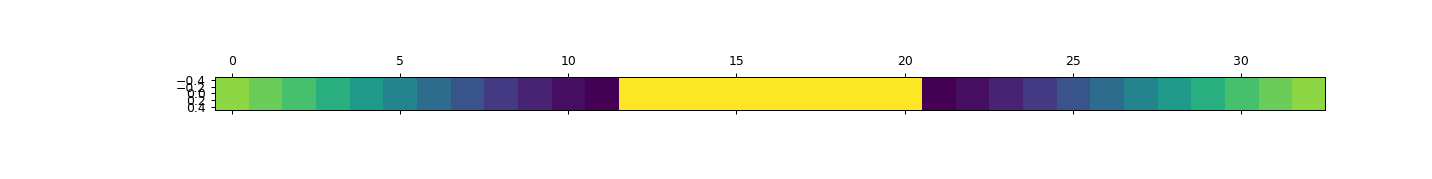

In [104]:
plt.rcParams['figure.figsize'] = [5, 5]

GCN = GCN1D(5000,
            16,
            1.5,
            25,
            globalTonic=10.,
            stdpWindow=5,
            dt=0.01,
            boostEffect=5,
            boostDecay=1000.,
            numPlaces=500,
            learningRate=10.,
            initialWeightFactor=.02,
            boostGradientX=150,
            weightDecay=500,
            wideningFactor=4,
            negativeLearnFactor=1.,
            envelopeWidth=10,
            envelopeFactor=2,
            sigmaLoc=.0005,
            gradientType="exponential",
            envSize=5,)

#GCN.randomLesions(10, 10, 5)

plt.matshow(GCN.filter[0,:])
plt.show()

# plt.matshow(GCN.envelope)
# plt.show()


# plt.matshow(GCN.boostEffect)
# plt.show()

# plt.figure()
# plt.scatter(GCN.places[:, 0].cpu().numpy(),
#              GCN.places[:, 1].cpu().numpy())
# plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 15]
for i in range(20):
    print(i)
    GCN.learn(20, plotting=False, plotInterval=10, offsets=np.random.random_sample(2,)*10)
    weights = GCN.placeWeights.cpu().numpy()
    with open("PlaceWeights{}.npz".format(i), "wb") as f:
        np.savez(f, weights)

0


<IPython.core.display.Javascript object>


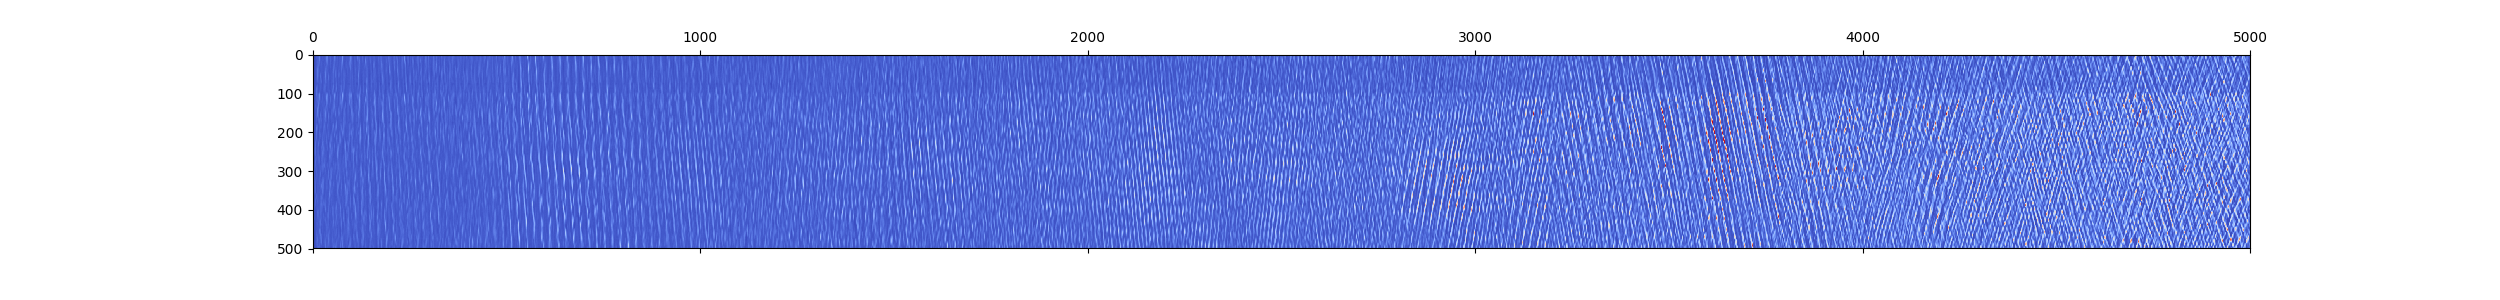

In [112]:
plt.rcParams['figure.figsize'] = [25, 3]
fig = plt.figure()
ax = plt.gca()
ax.matshow(torch.transpose(GCN.placeWeights, 0, 1).cpu().numpy()[:,],
                    cmap = plt.get_cmap("coolwarm"))
plt.show()

<IPython.core.display.Javascript object>


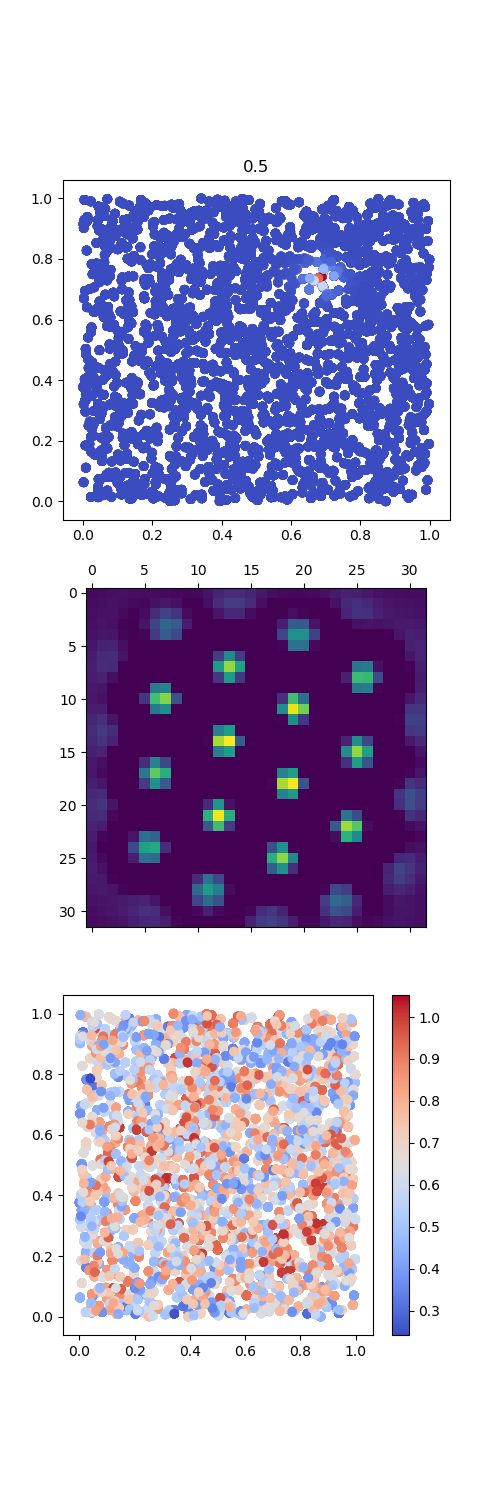

KeyboardInterrupt: 

In [112]:
plt.rcParams['figure.figsize'] = [5, 15]
GCN.learn(5000, plotting=True, plotInterval=5)

In [ ]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
start = 12
end = 20
for i in range(start, end):
    for j in range(start, end):
        index = (i - start)*(end - start) + (j - start) + 1
        plt.subplot((end - start), (end - start), index)
        plt.scatter(GCN.places[:, 0].cpu().numpy(),
                    GCN.places[:, 1].cpu().numpy(),
                    c = GCN.placeWeights[i, j, :].cpu().numpy(),
                    cmap = plt.get_cmap("coolwarm"))
        plt.draw()


In [387]:
plt.rcParams['figure.figsize'] = [5, 5]
results = GCN.simulate(1000, logFreq=1, startFrom = 0)[:,:]


At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.57
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.69
At 0.7
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.82
At 0.83
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.94
At 0.95
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 1.08
At 1.09
At 1.1
At 1.11
At 1.12
At 1.13
At 1.14
At 1.15
At 1.16
At 1.17
At 1.18
At 1.19
At 1.2
At 1.21
At 1.22
At 1.23
At 1.24
At 1.25
At 1.

At 11.12
At 11.13
At 11.14
At 11.15
At 11.16
At 11.17
At 11.18
At 11.19
At 11.2
At 11.21
At 11.22
At 11.23
At 11.24
At 11.25
At 11.26
At 11.27
At 11.28
At 11.29
At 11.3
At 11.31
At 11.32
At 11.33
At 11.34
At 11.35
At 11.36
At 11.37
At 11.38
At 11.39
At 11.4
At 11.41
At 11.42
At 11.43
At 11.44
At 11.45
At 11.46
At 11.47
At 11.48
At 11.49
At 11.5
At 11.51
At 11.52
At 11.53
At 11.54
At 11.55
At 11.56
At 11.57
At 11.58
At 11.59
At 11.6
At 11.61
At 11.62
At 11.63
At 11.64
At 11.65
At 11.66
At 11.67
At 11.68
At 11.69
At 11.7
At 11.71
At 11.72
At 11.73
At 11.74
At 11.75
At 11.76
At 11.77
At 11.78
At 11.79
At 11.8
At 11.81
At 11.82
At 11.83
At 11.84
At 11.85
At 11.86
At 11.87
At 11.88
At 11.89
At 11.9
At 11.91
At 11.92
At 11.93
At 11.94
At 11.95
At 11.96
At 11.97
At 11.98
At 11.99
At 12.0
At 12.01
At 12.02
At 12.03
At 12.04
At 12.05
At 12.06
At 12.07
At 12.08
At 12.09
At 12.1
At 12.11
At 12.12
At 12.13
At 12.14
At 12.15
At 12.16
At 12.17
At 12.18
At 12.19
At 12.2
At 12.21
At 12.22
At 12.23
At 

At 22.1
At 22.11
At 22.12
At 22.13
At 22.14
At 22.15
At 22.16
At 22.17
At 22.18
At 22.19
At 22.2
At 22.21
At 22.22
At 22.23
At 22.24
At 22.25
At 22.26
At 22.27
At 22.28
At 22.29
At 22.3
At 22.31
At 22.32
At 22.33
At 22.34
At 22.35
At 22.36
At 22.37
At 22.38
At 22.39
At 22.4
At 22.41
At 22.42
At 22.43
At 22.44
At 22.45
At 22.46
At 22.47
At 22.48
At 22.49
At 22.5
At 22.51
At 22.52
At 22.53
At 22.54
At 22.55
At 22.56
At 22.57
At 22.58
At 22.59
At 22.6
At 22.61
At 22.62
At 22.63
At 22.64
At 22.65
At 22.66
At 22.67
At 22.68
At 22.69
At 22.7
At 22.71
At 22.72
At 22.73
At 22.74
At 22.75
At 22.76
At 22.77
At 22.78
At 22.79
At 22.8
At 22.81
At 22.82
At 22.83
At 22.84
At 22.85
At 22.86
At 22.87
At 22.88
At 22.89
At 22.9
At 22.91
At 22.92
At 22.93
At 22.94
At 22.95
At 22.96
At 22.97
At 22.98
At 22.99
At 23.0
At 23.01
At 23.02
At 23.03
At 23.04
At 23.05
At 23.06
At 23.07
At 23.08
At 23.09
At 23.1
At 23.11
At 23.12
At 23.13
At 23.14
At 23.15
At 23.16
At 23.17
At 23.18
At 23.19
At 23.2
At 23.21
At 2

At 32.99
At 33.0
At 33.01
At 33.02
At 33.03
At 33.04
At 33.05
At 33.06
At 33.07
At 33.08
At 33.09
At 33.1
At 33.11
At 33.12
At 33.13
At 33.14
At 33.15
At 33.16
At 33.17
At 33.18
At 33.19
At 33.2
At 33.21
At 33.22
At 33.23
At 33.24
At 33.25
At 33.26
At 33.27
At 33.28
At 33.29
At 33.3
At 33.31
At 33.32
At 33.33
At 33.34
At 33.35
At 33.36
At 33.37
At 33.38
At 33.39
At 33.4
At 33.41
At 33.42
At 33.43
At 33.44
At 33.45
At 33.46
At 33.47
At 33.48
At 33.49
At 33.5
At 33.51
At 33.52
At 33.53
At 33.54
At 33.55
At 33.56
At 33.57
At 33.58
At 33.59
At 33.6
At 33.61
At 33.62
At 33.63
At 33.64
At 33.65
At 33.66
At 33.67
At 33.68
At 33.69
At 33.7
At 33.71
At 33.72
At 33.73
At 33.74
At 33.75
At 33.76
At 33.77
At 33.78
At 33.79
At 33.8
At 33.81
At 33.82
At 33.83
At 33.84
At 33.85
At 33.86
At 33.87
At 33.88
At 33.89
At 33.9
At 33.91
At 33.92
At 33.93
At 33.94
At 33.95
At 33.96
At 33.97
At 33.98
At 33.99
At 34.0
At 34.01
At 34.02
At 34.03
At 34.04
At 34.05
At 34.06
At 34.07
At 34.08
At 34.09
At 34.1
At 3

At 43.19
At 43.2
At 43.21
At 43.22
At 43.23
At 43.24
At 43.25
At 43.26
At 43.27
At 43.28
At 43.29
At 43.3
At 43.31
At 43.32
At 43.33
At 43.34
At 43.35
At 43.36
At 43.37
At 43.38
At 43.39
At 43.4
At 43.41
At 43.42
At 43.43
At 43.44
At 43.45
At 43.46
At 43.47
At 43.48
At 43.49
At 43.5
At 43.51
At 43.52
At 43.53
At 43.54
At 43.55
At 43.56
At 43.57
At 43.58
At 43.59
At 43.6
At 43.61
At 43.62
At 43.63
At 43.64
At 43.65
At 43.66
At 43.67
At 43.68
At 43.69
At 43.7
At 43.71
At 43.72
At 43.73
At 43.74
At 43.75
At 43.76
At 43.77
At 43.78
At 43.79
At 43.8
At 43.81
At 43.82
At 43.83
At 43.84
At 43.85
At 43.86
At 43.87
At 43.88
At 43.89
At 43.9
At 43.91
At 43.92
At 43.93
At 43.94
At 43.95
At 43.96
At 43.97
At 43.98
At 43.99
At 44.0
At 44.01
At 44.02
At 44.03
At 44.04
At 44.05
At 44.06
At 44.07
At 44.08
At 44.09
At 44.1
At 44.11
At 44.12
At 44.13
At 44.14
At 44.15
At 44.16
At 44.17
At 44.18
At 44.19
At 44.2
At 44.21
At 44.22
At 44.23
At 44.24
At 44.25
At 44.26
At 44.27
At 44.28
At 44.29
At 44.3
At 4

At 53.53
At 53.54
At 53.55
At 53.56
At 53.57
At 53.58
At 53.59
At 53.6
At 53.61
At 53.62
At 53.63
At 53.64
At 53.65
At 53.66
At 53.67
At 53.68
At 53.69
At 53.7
At 53.71
At 53.72
At 53.73
At 53.74
At 53.75
At 53.76
At 53.77
At 53.78
At 53.79
At 53.8
At 53.81
At 53.82
At 53.83
At 53.84
At 53.85
At 53.86
At 53.87
At 53.88
At 53.89
At 53.9
At 53.91
At 53.92
At 53.93
At 53.94
At 53.95
At 53.96
At 53.97
At 53.98
At 53.99
At 54.0
At 54.01
At 54.02
At 54.03
At 54.04
At 54.05
At 54.06
At 54.07
At 54.08
At 54.09
At 54.1
At 54.11
At 54.12
At 54.13
At 54.14
At 54.15
At 54.16
At 54.17
At 54.18
At 54.19
At 54.2
At 54.21
At 54.22
At 54.23
At 54.24
At 54.25
At 54.26
At 54.27
At 54.28
At 54.29
At 54.3
At 54.31
At 54.32
At 54.33
At 54.34
At 54.35
At 54.36
At 54.37
At 54.38
At 54.39
At 54.4
At 54.41
At 54.42
At 54.43
At 54.44
At 54.45
At 54.46
At 54.47
At 54.48
At 54.49
At 54.5
At 54.51
At 54.52
At 54.53
At 54.54
At 54.55
At 54.56
At 54.57
At 54.58
At 54.59
At 54.6
At 54.61
At 54.62
At 54.63
At 54.64
At 

At 64.53
At 64.54
At 64.55
At 64.56
At 64.57
At 64.58
At 64.59
At 64.6
At 64.61
At 64.62
At 64.63
At 64.64
At 64.65
At 64.66
At 64.67
At 64.68
At 64.69
At 64.7
At 64.71
At 64.72
At 64.73
At 64.74
At 64.75
At 64.76
At 64.77
At 64.78
At 64.79
At 64.8
At 64.81
At 64.82
At 64.83
At 64.84
At 64.85
At 64.86
At 64.87
At 64.88
At 64.89
At 64.9
At 64.91
At 64.92
At 64.93
At 64.94
At 64.95
At 64.96
At 64.97
At 64.98
At 64.99
At 65.0
At 65.01
At 65.02
At 65.03
At 65.04
At 65.05
At 65.06
At 65.07
At 65.08
At 65.09
At 65.1
At 65.11
At 65.12
At 65.13
At 65.14
At 65.15
At 65.16
At 65.17
At 65.18
At 65.19
At 65.2
At 65.21
At 65.22
At 65.23
At 65.24
At 65.25
At 65.26
At 65.27
At 65.28
At 65.29
At 65.3
At 65.31
At 65.32
At 65.33
At 65.34
At 65.35
At 65.36
At 65.37
At 65.38
At 65.39
At 65.4
At 65.41
At 65.42
At 65.43
At 65.44
At 65.45
At 65.46
At 65.47
At 65.48
At 65.49
At 65.5
At 65.51
At 65.52
At 65.53
At 65.54
At 65.55
At 65.56
At 65.57
At 65.58
At 65.59
At 65.6
At 65.61
At 65.62
At 65.63
At 65.64
At 

At 74.98
At 74.99
At 75.0
At 75.01
At 75.02
At 75.03
At 75.04
At 75.05
At 75.06
At 75.07
At 75.08
At 75.09
At 75.1
At 75.11
At 75.12
At 75.13
At 75.14
At 75.15
At 75.16
At 75.17
At 75.18
At 75.19
At 75.2
At 75.21
At 75.22
At 75.23
At 75.24
At 75.25
At 75.26
At 75.27
At 75.28
At 75.29
At 75.3
At 75.31
At 75.32
At 75.33
At 75.34
At 75.35
At 75.36
At 75.37
At 75.38
At 75.39
At 75.4
At 75.41
At 75.42
At 75.43
At 75.44
At 75.45
At 75.46
At 75.47
At 75.48
At 75.49
At 75.5
At 75.51
At 75.52
At 75.53
At 75.54
At 75.55
At 75.56
At 75.57
At 75.58
At 75.59
At 75.6
At 75.61
At 75.62
At 75.63
At 75.64
At 75.65
At 75.66
At 75.67
At 75.68
At 75.69
At 75.7
At 75.71
At 75.72
At 75.73
At 75.74
At 75.75
At 75.76
At 75.77
At 75.78
At 75.79
At 75.8
At 75.81
At 75.82
At 75.83
At 75.84
At 75.85
At 75.86
At 75.87
At 75.88
At 75.89
At 75.9
At 75.91
At 75.92
At 75.93
At 75.94
At 75.95
At 75.96
At 75.97
At 75.98
At 75.99
At 76.0
At 76.01
At 76.02
At 76.03
At 76.04
At 76.05
At 76.06
At 76.07
At 76.08
At 76.09
At 

At 85.57
At 85.58
At 85.59
At 85.6
At 85.61
At 85.62
At 85.63
At 85.64
At 85.65
At 85.66
At 85.67
At 85.68
At 85.69
At 85.7
At 85.71
At 85.72
At 85.73
At 85.74
At 85.75
At 85.76
At 85.77
At 85.78
At 85.79
At 85.8
At 85.81
At 85.82
At 85.83
At 85.84
At 85.85
At 85.86
At 85.87
At 85.88
At 85.89
At 85.9
At 85.91
At 85.92
At 85.93
At 85.94
At 85.95
At 85.96
At 85.97
At 85.98
At 85.99
At 86.0
At 86.01
At 86.02
At 86.03
At 86.04
At 86.05
At 86.06
At 86.07
At 86.08
At 86.09
At 86.1
At 86.11
At 86.12
At 86.13
At 86.14
At 86.15
At 86.16
At 86.17
At 86.18
At 86.19
At 86.2
At 86.21
At 86.22
At 86.23
At 86.24
At 86.25
At 86.26
At 86.27
At 86.28
At 86.29
At 86.3
At 86.31
At 86.32
At 86.33
At 86.34
At 86.35
At 86.36
At 86.37
At 86.38
At 86.39
At 86.4
At 86.41
At 86.42
At 86.43
At 86.44
At 86.45
At 86.46
At 86.47
At 86.48
At 86.49
At 86.5
At 86.51
At 86.52
At 86.53
At 86.54
At 86.55
At 86.56
At 86.57
At 86.58
At 86.59
At 86.6
At 86.61
At 86.62
At 86.63
At 86.64
At 86.65
At 86.66
At 86.67
At 86.68
At 

At 96.22
At 96.23
At 96.24
At 96.25
At 96.26
At 96.27
At 96.28
At 96.29
At 96.3
At 96.31
At 96.32
At 96.33
At 96.34
At 96.35
At 96.36
At 96.37
At 96.38
At 96.39
At 96.4
At 96.41
At 96.42
At 96.43
At 96.44
At 96.45
At 96.46
At 96.47
At 96.48
At 96.49
At 96.5
At 96.51
At 96.52
At 96.53
At 96.54
At 96.55
At 96.56
At 96.57
At 96.58
At 96.59
At 96.6
At 96.61
At 96.62
At 96.63
At 96.64
At 96.65
At 96.66
At 96.67
At 96.68
At 96.69
At 96.7
At 96.71
At 96.72
At 96.73
At 96.74
At 96.75
At 96.76
At 96.77
At 96.78
At 96.79
At 96.8
At 96.81
At 96.82
At 96.83
At 96.84
At 96.85
At 96.86
At 96.87
At 96.88
At 96.89
At 96.9
At 96.91
At 96.92
At 96.93
At 96.94
At 96.95
At 96.96
At 96.97
At 96.98
At 96.99
At 97.0
At 97.01
At 97.02
At 97.03
At 97.04
At 97.05
At 97.06
At 97.07
At 97.08
At 97.09
At 97.1
At 97.11
At 97.12
At 97.13
At 97.14
At 97.15
At 97.16
At 97.17
At 97.18
At 97.19
At 97.2
At 97.21
At 97.22
At 97.23
At 97.24
At 97.25
At 97.26
At 97.27
At 97.28
At 97.29
At 97.3
At 97.31
At 97.32
At 97.33
At 

At 106.85
At 106.86
At 106.87
At 106.88
At 106.89
At 106.9
At 106.91
At 106.92
At 106.93
At 106.94
At 106.95
At 106.96
At 106.97
At 106.98
At 106.99
At 107.0
At 107.01
At 107.02
At 107.03
At 107.04
At 107.05
At 107.06
At 107.07
At 107.08
At 107.09
At 107.1
At 107.11
At 107.12
At 107.13
At 107.14
At 107.15
At 107.16
At 107.17
At 107.18
At 107.19
At 107.2
At 107.21
At 107.22
At 107.23
At 107.24
At 107.25
At 107.26
At 107.27
At 107.28
At 107.29
At 107.3
At 107.31
At 107.32
At 107.33
At 107.34
At 107.35
At 107.36
At 107.37
At 107.38
At 107.39
At 107.4
At 107.41
At 107.42
At 107.43
At 107.44
At 107.45
At 107.46
At 107.47
At 107.48
At 107.49
At 107.5
At 107.51
At 107.52
At 107.53
At 107.54
At 107.55
At 107.56
At 107.57
At 107.58
At 107.59
At 107.6
At 107.61
At 107.62
At 107.63
At 107.64
At 107.65
At 107.66
At 107.67
At 107.68
At 107.69
At 107.7
At 107.71
At 107.72
At 107.73
At 107.74
At 107.75
At 107.76
At 107.77
At 107.78
At 107.79
At 107.8
At 107.81
At 107.82
At 107.83
At 107.84
At 107.85


At 117.52
At 117.53
At 117.54
At 117.55
At 117.56
At 117.57
At 117.58
At 117.59
At 117.6
At 117.61
At 117.62
At 117.63
At 117.64
At 117.65
At 117.66
At 117.67
At 117.68
At 117.69
At 117.7
At 117.71
At 117.72
At 117.73
At 117.74
At 117.75
At 117.76
At 117.77
At 117.78
At 117.79
At 117.8
At 117.81
At 117.82
At 117.83
At 117.84
At 117.85
At 117.86
At 117.87
At 117.88
At 117.89
At 117.9
At 117.91
At 117.92
At 117.93
At 117.94
At 117.95
At 117.96
At 117.97
At 117.98
At 117.99
At 118.0
At 118.01
At 118.02
At 118.03
At 118.04
At 118.05
At 118.06
At 118.07
At 118.08
At 118.09
At 118.1
At 118.11
At 118.12
At 118.13
At 118.14
At 118.15
At 118.16
At 118.17
At 118.18
At 118.19
At 118.2
At 118.21
At 118.22
At 118.23
At 118.24
At 118.25
At 118.26
At 118.27
At 118.28
At 118.29
At 118.3
At 118.31
At 118.32
At 118.33
At 118.34
At 118.35
At 118.36
At 118.37
At 118.38
At 118.39
At 118.4
At 118.41
At 118.42
At 118.43
At 118.44
At 118.45
At 118.46
At 118.47
At 118.48
At 118.49
At 118.5
At 118.51
At 118.52


At 127.36
At 127.37
At 127.38
At 127.39
At 127.4
At 127.41
At 127.42
At 127.43
At 127.44
At 127.45
At 127.46
At 127.47
At 127.48
At 127.49
At 127.5
At 127.51
At 127.52
At 127.53
At 127.54
At 127.55
At 127.56
At 127.57
At 127.58
At 127.59
At 127.6
At 127.61
At 127.62
At 127.63
At 127.64
At 127.65
At 127.66
At 127.67
At 127.68
At 127.69
At 127.7
At 127.71
At 127.72
At 127.73
At 127.74
At 127.75
At 127.76
At 127.77
At 127.78
At 127.79
At 127.8
At 127.81
At 127.82
At 127.83
At 127.84
At 127.85
At 127.86
At 127.87
At 127.88
At 127.89
At 127.9
At 127.91
At 127.92
At 127.93
At 127.94
At 127.95
At 127.96
At 127.97
At 127.98
At 127.99
At 128.0
At 128.01
At 128.02
At 128.03
At 128.04
At 128.05
At 128.06
At 128.07
At 128.08
At 128.09
At 128.1
At 128.11
At 128.12
At 128.13
At 128.14
At 128.15
At 128.16
At 128.17
At 128.18
At 128.19
At 128.2
At 128.21
At 128.22
At 128.23
At 128.24
At 128.25
At 128.26
At 128.27
At 128.28
At 128.29
At 128.3
At 128.31
At 128.32
At 128.33
At 128.34
At 128.35
At 128.36


At 136.94
At 136.95
At 136.96
At 136.97
At 136.98
At 136.99
At 137.0
At 137.01
At 137.02
At 137.03
At 137.04
At 137.05
At 137.06
At 137.07
At 137.08
At 137.09
At 137.1
At 137.11
At 137.12
At 137.13
At 137.14
At 137.15
At 137.16
At 137.17
At 137.18
At 137.19
At 137.2
At 137.21
At 137.22
At 137.23
At 137.24
At 137.25
At 137.26
At 137.27
At 137.28
At 137.29
At 137.3
At 137.31
At 137.32
At 137.33
At 137.34
At 137.35
At 137.36
At 137.37
At 137.38
At 137.39
At 137.4
At 137.41
At 137.42
At 137.43
At 137.44
At 137.45
At 137.46
At 137.47
At 137.48
At 137.49
At 137.5
At 137.51
At 137.52
At 137.53
At 137.54
At 137.55
At 137.56
At 137.57
At 137.58
At 137.59
At 137.6
At 137.61
At 137.62
At 137.63
At 137.64
At 137.65
At 137.66
At 137.67
At 137.68
At 137.69
At 137.7
At 137.71
At 137.72
At 137.73
At 137.74
At 137.75
At 137.76
At 137.77
At 137.78
At 137.79
At 137.8
At 137.81
At 137.82
At 137.83
At 137.84
At 137.85
At 137.86
At 137.87
At 137.88
At 137.89
At 137.9
At 137.91
At 137.92
At 137.93
At 137.94


At 146.99
At 147.0
At 147.01
At 147.02
At 147.03
At 147.04
At 147.05
At 147.06
At 147.07
At 147.08
At 147.09
At 147.1
At 147.11
At 147.12
At 147.13
At 147.14
At 147.15
At 147.16
At 147.17
At 147.18
At 147.19
At 147.2
At 147.21
At 147.22
At 147.23
At 147.24
At 147.25
At 147.26
At 147.27
At 147.28
At 147.29
At 147.3
At 147.31
At 147.32
At 147.33
At 147.34
At 147.35
At 147.36
At 147.37
At 147.38
At 147.39
At 147.4
At 147.41
At 147.42
At 147.43
At 147.44
At 147.45
At 147.46
At 147.47
At 147.48
At 147.49
At 147.5
At 147.51
At 147.52
At 147.53
At 147.54
At 147.55
At 147.56
At 147.57
At 147.58
At 147.59
At 147.6
At 147.61
At 147.62
At 147.63
At 147.64
At 147.65
At 147.66
At 147.67
At 147.68
At 147.69
At 147.7
At 147.71
At 147.72
At 147.73
At 147.74
At 147.75
At 147.76
At 147.77
At 147.78
At 147.79
At 147.8
At 147.81
At 147.82
At 147.83
At 147.84
At 147.85
At 147.86
At 147.87
At 147.88
At 147.89
At 147.9
At 147.91
At 147.92
At 147.93
At 147.94
At 147.95
At 147.96
At 147.97
At 147.98
At 147.99


At 156.7
At 156.71
At 156.72
At 156.73
At 156.74
At 156.75
At 156.76
At 156.77
At 156.78
At 156.79
At 156.8
At 156.81
At 156.82
At 156.83
At 156.84
At 156.85
At 156.86
At 156.87
At 156.88
At 156.89
At 156.9
At 156.91
At 156.92
At 156.93
At 156.94
At 156.95
At 156.96
At 156.97
At 156.98
At 156.99
At 157.0
At 157.01
At 157.02
At 157.03
At 157.04
At 157.05
At 157.06
At 157.07
At 157.08
At 157.09
At 157.1
At 157.11
At 157.12
At 157.13
At 157.14
At 157.15
At 157.16
At 157.17
At 157.18
At 157.19
At 157.2
At 157.21
At 157.22
At 157.23
At 157.24
At 157.25
At 157.26
At 157.27
At 157.28
At 157.29
At 157.3
At 157.31
At 157.32
At 157.33
At 157.34
At 157.35
At 157.36
At 157.37
At 157.38
At 157.39
At 157.4
At 157.41
At 157.42
At 157.43
At 157.44
At 157.45
At 157.46
At 157.47
At 157.48
At 157.49
At 157.5
At 157.51
At 157.52
At 157.53
At 157.54
At 157.55
At 157.56
At 157.57
At 157.58
At 157.59
At 157.6
At 157.61
At 157.62
At 157.63
At 157.64
At 157.65
At 157.66
At 157.67
At 157.68
At 157.69
At 157.7
A

At 166.45
At 166.46
At 166.47
At 166.48
At 166.49
At 166.5
At 166.51
At 166.52
At 166.53
At 166.54
At 166.55
At 166.56
At 166.57
At 166.58
At 166.59
At 166.6
At 166.61
At 166.62
At 166.63
At 166.64
At 166.65
At 166.66
At 166.67
At 166.68
At 166.69
At 166.7
At 166.71
At 166.72
At 166.73
At 166.74
At 166.75
At 166.76
At 166.77
At 166.78
At 166.79
At 166.8
At 166.81
At 166.82
At 166.83
At 166.84
At 166.85
At 166.86
At 166.87
At 166.88
At 166.89
At 166.9
At 166.91
At 166.92
At 166.93
At 166.94
At 166.95
At 166.96
At 166.97
At 166.98
At 166.99
At 167.0
At 167.01
At 167.02
At 167.03
At 167.04
At 167.05
At 167.06
At 167.07
At 167.08
At 167.09
At 167.1
At 167.11
At 167.12
At 167.13
At 167.14
At 167.15
At 167.16
At 167.17
At 167.18
At 167.19
At 167.2
At 167.21
At 167.22
At 167.23
At 167.24
At 167.25
At 167.26
At 167.27
At 167.28
At 167.29
At 167.3
At 167.31
At 167.32
At 167.33
At 167.34
At 167.35
At 167.36
At 167.37
At 167.38
At 167.39
At 167.4
At 167.41
At 167.42
At 167.43
At 167.44
At 167.45


At 175.71
At 175.72
At 175.73
At 175.74
At 175.75
At 175.76
At 175.77
At 175.78
At 175.79
At 175.8
At 175.81
At 175.82
At 175.83
At 175.84
At 175.85
At 175.86
At 175.87
At 175.88
At 175.89
At 175.9
At 175.91
At 175.92
At 175.93
At 175.94
At 175.95
At 175.96
At 175.97
At 175.98
At 175.99
At 176.0
At 176.01
At 176.02
At 176.03
At 176.04
At 176.05
At 176.06
At 176.07
At 176.08
At 176.09
At 176.1
At 176.11
At 176.12
At 176.13
At 176.14
At 176.15
At 176.16
At 176.17
At 176.18
At 176.19
At 176.2
At 176.21
At 176.22
At 176.23
At 176.24
At 176.25
At 176.26
At 176.27
At 176.28
At 176.29
At 176.3
At 176.31
At 176.32
At 176.33
At 176.34
At 176.35
At 176.36
At 176.37
At 176.38
At 176.39
At 176.4
At 176.41
At 176.42
At 176.43
At 176.44
At 176.45
At 176.46
At 176.47
At 176.48
At 176.49
At 176.5
At 176.51
At 176.52
At 176.53
At 176.54
At 176.55
At 176.56
At 176.57
At 176.58
At 176.59
At 176.6
At 176.61
At 176.62
At 176.63
At 176.64
At 176.65
At 176.66
At 176.67
At 176.68
At 176.69
At 176.7
At 176.71


At 185.13
At 185.14
At 185.15
At 185.16
At 185.17
At 185.18
At 185.19
At 185.2
At 185.21
At 185.22
At 185.23
At 185.24
At 185.25
At 185.26
At 185.27
At 185.28
At 185.29
At 185.3
At 185.31
At 185.32
At 185.33
At 185.34
At 185.35
At 185.36
At 185.37
At 185.38
At 185.39
At 185.4
At 185.41
At 185.42
At 185.43
At 185.44
At 185.45
At 185.46
At 185.47
At 185.48
At 185.49
At 185.5
At 185.51
At 185.52
At 185.53
At 185.54
At 185.55
At 185.56
At 185.57
At 185.58
At 185.59
At 185.6
At 185.61
At 185.62
At 185.63
At 185.64
At 185.65
At 185.66
At 185.67
At 185.68
At 185.69
At 185.7
At 185.71
At 185.72
At 185.73
At 185.74
At 185.75
At 185.76
At 185.77
At 185.78
At 185.79
At 185.8
At 185.81
At 185.82
At 185.83
At 185.84
At 185.85
At 185.86
At 185.87
At 185.88
At 185.89
At 185.9
At 185.91
At 185.92
At 185.93
At 185.94
At 185.95
At 185.96
At 185.97
At 185.98
At 185.99
At 186.0
At 186.01
At 186.02
At 186.03
At 186.04
At 186.05
At 186.06
At 186.07
At 186.08
At 186.09
At 186.1
At 186.11
At 186.12
At 186.13


At 194.58
At 194.59
At 194.6
At 194.61
At 194.62
At 194.63
At 194.64
At 194.65
At 194.66
At 194.67
At 194.68
At 194.69
At 194.7
At 194.71
At 194.72
At 194.73
At 194.74
At 194.75
At 194.76
At 194.77
At 194.78
At 194.79
At 194.8
At 194.81
At 194.82
At 194.83
At 194.84
At 194.85
At 194.86
At 194.87
At 194.88
At 194.89
At 194.9
At 194.91
At 194.92
At 194.93
At 194.94
At 194.95
At 194.96
At 194.97
At 194.98
At 194.99
At 195.0
At 195.01
At 195.02
At 195.03
At 195.04
At 195.05
At 195.06
At 195.07
At 195.08
At 195.09
At 195.1
At 195.11
At 195.12
At 195.13
At 195.14
At 195.15
At 195.16
At 195.17
At 195.18
At 195.19
At 195.2
At 195.21
At 195.22
At 195.23
At 195.24
At 195.25
At 195.26
At 195.27
At 195.28
At 195.29
At 195.3
At 195.31
At 195.32
At 195.33
At 195.34
At 195.35
At 195.36
At 195.37
At 195.38
At 195.39
At 195.4
At 195.41
At 195.42
At 195.43
At 195.44
At 195.45
At 195.46
At 195.47
At 195.48
At 195.49
At 195.5
At 195.51
At 195.52
At 195.53
At 195.54
At 195.55
At 195.56
At 195.57
At 195.58


At 204.13
At 204.14
At 204.15
At 204.16
At 204.17
At 204.18
At 204.19
At 204.2
At 204.21
At 204.22
At 204.23
At 204.24
At 204.25
At 204.26
At 204.27
At 204.28
At 204.29
At 204.3
At 204.31
At 204.32
At 204.33
At 204.34
At 204.35
At 204.36
At 204.37
At 204.38
At 204.39
At 204.4
At 204.41
At 204.42
At 204.43
At 204.44
At 204.45
At 204.46
At 204.47
At 204.48
At 204.49
At 204.5
At 204.51
At 204.52
At 204.53
At 204.54
At 204.55
At 204.56
At 204.57
At 204.58
At 204.59
At 204.6
At 204.61
At 204.62
At 204.63
At 204.64
At 204.65
At 204.66
At 204.67
At 204.68
At 204.69
At 204.7
At 204.71
At 204.72
At 204.73
At 204.74
At 204.75
At 204.76
At 204.77
At 204.78
At 204.79
At 204.8
At 204.81
At 204.82
At 204.83
At 204.84
At 204.85
At 204.86
At 204.87
At 204.88
At 204.89
At 204.9
At 204.91
At 204.92
At 204.93
At 204.94
At 204.95
At 204.96
At 204.97
At 204.98
At 204.99
At 205.0
At 205.01
At 205.02
At 205.03
At 205.04
At 205.05
At 205.06
At 205.07
At 205.08
At 205.09
At 205.1
At 205.11
At 205.12
At 205.13


At 213.93
At 213.94
At 213.95
At 213.96
At 213.97
At 213.98
At 213.99
At 214.0
At 214.01
At 214.02
At 214.03
At 214.04
At 214.05
At 214.06
At 214.07
At 214.08
At 214.09
At 214.1
At 214.11
At 214.12
At 214.13
At 214.14
At 214.15
At 214.16
At 214.17
At 214.18
At 214.19
At 214.2
At 214.21
At 214.22
At 214.23
At 214.24
At 214.25
At 214.26
At 214.27
At 214.28
At 214.29
At 214.3
At 214.31
At 214.32
At 214.33
At 214.34
At 214.35
At 214.36
At 214.37
At 214.38
At 214.39
At 214.4
At 214.41
At 214.42
At 214.43
At 214.44
At 214.45
At 214.46
At 214.47
At 214.48
At 214.49
At 214.5
At 214.51
At 214.52
At 214.53
At 214.54
At 214.55
At 214.56
At 214.57
At 214.58
At 214.59
At 214.6
At 214.61
At 214.62
At 214.63
At 214.64
At 214.65
At 214.66
At 214.67
At 214.68
At 214.69
At 214.7
At 214.71
At 214.72
At 214.73
At 214.74
At 214.75
At 214.76
At 214.77
At 214.78
At 214.79
At 214.8
At 214.81
At 214.82
At 214.83
At 214.84
At 214.85
At 214.86
At 214.87
At 214.88
At 214.89
At 214.9
At 214.91
At 214.92
At 214.93


At 223.81
At 223.82
At 223.83
At 223.84
At 223.85
At 223.86
At 223.87
At 223.88
At 223.89
At 223.9
At 223.91
At 223.92
At 223.93
At 223.94
At 223.95
At 223.96
At 223.97
At 223.98
At 223.99
At 224.0
At 224.01
At 224.02
At 224.03
At 224.04
At 224.05
At 224.06
At 224.07
At 224.08
At 224.09
At 224.1
At 224.11
At 224.12
At 224.13
At 224.14
At 224.15
At 224.16
At 224.17
At 224.18
At 224.19
At 224.2
At 224.21
At 224.22
At 224.23
At 224.24
At 224.25
At 224.26
At 224.27
At 224.28
At 224.29
At 224.3
At 224.31
At 224.32
At 224.33
At 224.34
At 224.35
At 224.36
At 224.37
At 224.38
At 224.39
At 224.4
At 224.41
At 224.42
At 224.43
At 224.44
At 224.45
At 224.46
At 224.47
At 224.48
At 224.49
At 224.5
At 224.51
At 224.52
At 224.53
At 224.54
At 224.55
At 224.56
At 224.57
At 224.58
At 224.59
At 224.6
At 224.61
At 224.62
At 224.63
At 224.64
At 224.65
At 224.66
At 224.67
At 224.68
At 224.69
At 224.7
At 224.71
At 224.72
At 224.73
At 224.74
At 224.75
At 224.76
At 224.77
At 224.78
At 224.79
At 224.8
At 224.81


At 233.71
At 233.72
At 233.73
At 233.74
At 233.75
At 233.76
At 233.77
At 233.78
At 233.79
At 233.8
At 233.81
At 233.82
At 233.83
At 233.84
At 233.85
At 233.86
At 233.87
At 233.88
At 233.89
At 233.9
At 233.91
At 233.92
At 233.93
At 233.94
At 233.95
At 233.96
At 233.97
At 233.98
At 233.99
At 234.0
At 234.01
At 234.02
At 234.03
At 234.04
At 234.05
At 234.06
At 234.07
At 234.08
At 234.09
At 234.1
At 234.11
At 234.12
At 234.13
At 234.14
At 234.15
At 234.16
At 234.17
At 234.18
At 234.19
At 234.2
At 234.21
At 234.22
At 234.23
At 234.24
At 234.25
At 234.26
At 234.27
At 234.28
At 234.29
At 234.3
At 234.31
At 234.32
At 234.33
At 234.34
At 234.35
At 234.36
At 234.37
At 234.38
At 234.39
At 234.4
At 234.41
At 234.42
At 234.43
At 234.44
At 234.45
At 234.46
At 234.47
At 234.48
At 234.49
At 234.5
At 234.51
At 234.52
At 234.53
At 234.54
At 234.55
At 234.56
At 234.57
At 234.58
At 234.59
At 234.6
At 234.61
At 234.62
At 234.63
At 234.64
At 234.65
At 234.66
At 234.67
At 234.68
At 234.69
At 234.7
At 234.71


At 243.63
At 243.64
At 243.65
At 243.66
At 243.67
At 243.68
At 243.69
At 243.7
At 243.71
At 243.72
At 243.73
At 243.74
At 243.75
At 243.76
At 243.77
At 243.78
At 243.79
At 243.8
At 243.81
At 243.82
At 243.83
At 243.84
At 243.85
At 243.86
At 243.87
At 243.88
At 243.89
At 243.9
At 243.91
At 243.92
At 243.93
At 243.94
At 243.95
At 243.96
At 243.97
At 243.98
At 243.99
At 244.0
At 244.01
At 244.02
At 244.03
At 244.04
At 244.05
At 244.06
At 244.07
At 244.08
At 244.09
At 244.1
At 244.11
At 244.12
At 244.13
At 244.14
At 244.15
At 244.16
At 244.17
At 244.18
At 244.19
At 244.2
At 244.21
At 244.22
At 244.23
At 244.24
At 244.25
At 244.26
At 244.27
At 244.28
At 244.29
At 244.3
At 244.31
At 244.32
At 244.33
At 244.34
At 244.35
At 244.36
At 244.37
At 244.38
At 244.39
At 244.4
At 244.41
At 244.42
At 244.43
At 244.44
At 244.45
At 244.46
At 244.47
At 244.48
At 244.49
At 244.5
At 244.51
At 244.52
At 244.53
At 244.54
At 244.55
At 244.56
At 244.57
At 244.58
At 244.59
At 244.6
At 244.61
At 244.62
At 244.63


At 253.57
At 253.58
At 253.59
At 253.6
At 253.61
At 253.62
At 253.63
At 253.64
At 253.65
At 253.66
At 253.67
At 253.68
At 253.69
At 253.7
At 253.71
At 253.72
At 253.73
At 253.74
At 253.75
At 253.76
At 253.77
At 253.78
At 253.79
At 253.8
At 253.81
At 253.82
At 253.83
At 253.84
At 253.85
At 253.86
At 253.87
At 253.88
At 253.89
At 253.9
At 253.91
At 253.92
At 253.93
At 253.94
At 253.95
At 253.96
At 253.97
At 253.98
At 253.99
At 254.0
At 254.01
At 254.02
At 254.03
At 254.04
At 254.05
At 254.06
At 254.07
At 254.08
At 254.09
At 254.1
At 254.11
At 254.12
At 254.13
At 254.14
At 254.15
At 254.16
At 254.17
At 254.18
At 254.19
At 254.2
At 254.21
At 254.22
At 254.23
At 254.24
At 254.25
At 254.26
At 254.27
At 254.28
At 254.29
At 254.3
At 254.31
At 254.32
At 254.33
At 254.34
At 254.35
At 254.36
At 254.37
At 254.38
At 254.39
At 254.4
At 254.41
At 254.42
At 254.43
At 254.44
At 254.45
At 254.46
At 254.47
At 254.48
At 254.49
At 254.5
At 254.51
At 254.52
At 254.53
At 254.54
At 254.55
At 254.56
At 254.57


At 263.57
At 263.58
At 263.59
At 263.6
At 263.61
At 263.62
At 263.63
At 263.64
At 263.65
At 263.66
At 263.67
At 263.68
At 263.69
At 263.7
At 263.71
At 263.72
At 263.73
At 263.74
At 263.75
At 263.76
At 263.77
At 263.78
At 263.79
At 263.8
At 263.81
At 263.82
At 263.83
At 263.84
At 263.85
At 263.86
At 263.87
At 263.88
At 263.89
At 263.9
At 263.91
At 263.92
At 263.93
At 263.94
At 263.95
At 263.96
At 263.97
At 263.98
At 263.99
At 264.0
At 264.01
At 264.02
At 264.03
At 264.04
At 264.05
At 264.06
At 264.07
At 264.08
At 264.09
At 264.1
At 264.11
At 264.12
At 264.13
At 264.14
At 264.15
At 264.16
At 264.17
At 264.18
At 264.19
At 264.2
At 264.21
At 264.22
At 264.23
At 264.24
At 264.25
At 264.26
At 264.27
At 264.28
At 264.29
At 264.3
At 264.31
At 264.32
At 264.33
At 264.34
At 264.35
At 264.36
At 264.37
At 264.38
At 264.39
At 264.4
At 264.41
At 264.42
At 264.43
At 264.44
At 264.45
At 264.46
At 264.47
At 264.48
At 264.49
At 264.5
At 264.51
At 264.52
At 264.53
At 264.54
At 264.55
At 264.56
At 264.57


At 273.59
At 273.6
At 273.61
At 273.62
At 273.63
At 273.64
At 273.65
At 273.66
At 273.67
At 273.68
At 273.69
At 273.7
At 273.71
At 273.72
At 273.73
At 273.74
At 273.75
At 273.76
At 273.77
At 273.78
At 273.79
At 273.8
At 273.81
At 273.82
At 273.83
At 273.84
At 273.85
At 273.86
At 273.87
At 273.88
At 273.89
At 273.9
At 273.91
At 273.92
At 273.93
At 273.94
At 273.95
At 273.96
At 273.97
At 273.98
At 273.99
At 274.0
At 274.01
At 274.02
At 274.03
At 274.04
At 274.05
At 274.06
At 274.07
At 274.08
At 274.09
At 274.1
At 274.11
At 274.12
At 274.13
At 274.14
At 274.15
At 274.16
At 274.17
At 274.18
At 274.19
At 274.2
At 274.21
At 274.22
At 274.23
At 274.24
At 274.25
At 274.26
At 274.27
At 274.28
At 274.29
At 274.3
At 274.31
At 274.32
At 274.33
At 274.34
At 274.35
At 274.36
At 274.37
At 274.38
At 274.39
At 274.4
At 274.41
At 274.42
At 274.43
At 274.44
At 274.45
At 274.46
At 274.47
At 274.48
At 274.49
At 274.5
At 274.51
At 274.52
At 274.53
At 274.54
At 274.55
At 274.56
At 274.57
At 274.58
At 274.59


At 283.91
At 283.92
At 283.93
At 283.94
At 283.95
At 283.96
At 283.97
At 283.98
At 283.99
At 284.0
At 284.01
At 284.02
At 284.03
At 284.04
At 284.05
At 284.06
At 284.07
At 284.08
At 284.09
At 284.1
At 284.11
At 284.12
At 284.13
At 284.14
At 284.15
At 284.16
At 284.17
At 284.18
At 284.19
At 284.2
At 284.21
At 284.22
At 284.23
At 284.24
At 284.25
At 284.26
At 284.27
At 284.28
At 284.29
At 284.3
At 284.31
At 284.32
At 284.33
At 284.34
At 284.35
At 284.36
At 284.37
At 284.38
At 284.39
At 284.4
At 284.41
At 284.42
At 284.43
At 284.44
At 284.45
At 284.46
At 284.47
At 284.48
At 284.49
At 284.5
At 284.51
At 284.52
At 284.53
At 284.54
At 284.55
At 284.56
At 284.57
At 284.58
At 284.59
At 284.6
At 284.61
At 284.62
At 284.63
At 284.64
At 284.65
At 284.66
At 284.67
At 284.68
At 284.69
At 284.7
At 284.71
At 284.72
At 284.73
At 284.74
At 284.75
At 284.76
At 284.77
At 284.78
At 284.79
At 284.8
At 284.81
At 284.82
At 284.83
At 284.84
At 284.85
At 284.86
At 284.87
At 284.88
At 284.89
At 284.9
At 284.91


At 294.24
At 294.25
At 294.26
At 294.27
At 294.28
At 294.29
At 294.3
At 294.31
At 294.32
At 294.33
At 294.34
At 294.35
At 294.36
At 294.37
At 294.38
At 294.39
At 294.4
At 294.41
At 294.42
At 294.43
At 294.44
At 294.45
At 294.46
At 294.47
At 294.48
At 294.49
At 294.5
At 294.51
At 294.52
At 294.53
At 294.54
At 294.55
At 294.56
At 294.57
At 294.58
At 294.59
At 294.6
At 294.61
At 294.62
At 294.63
At 294.64
At 294.65
At 294.66
At 294.67
At 294.68
At 294.69
At 294.7
At 294.71
At 294.72
At 294.73
At 294.74
At 294.75
At 294.76
At 294.77
At 294.78
At 294.79
At 294.8
At 294.81
At 294.82
At 294.83
At 294.84
At 294.85
At 294.86
At 294.87
At 294.88
At 294.89
At 294.9
At 294.91
At 294.92
At 294.93
At 294.94
At 294.95
At 294.96
At 294.97
At 294.98
At 294.99
At 295.0
At 295.01
At 295.02
At 295.03
At 295.04
At 295.05
At 295.06
At 295.07
At 295.08
At 295.09
At 295.1
At 295.11
At 295.12
At 295.13
At 295.14
At 295.15
At 295.16
At 295.17
At 295.18
At 295.19
At 295.2
At 295.21
At 295.22
At 295.23
At 295.24


At 304.68
At 304.69
At 304.7
At 304.71
At 304.72
At 304.73
At 304.74
At 304.75
At 304.76
At 304.77
At 304.78
At 304.79
At 304.8
At 304.81
At 304.82
At 304.83
At 304.84
At 304.85
At 304.86
At 304.87
At 304.88
At 304.89
At 304.9
At 304.91
At 304.92
At 304.93
At 304.94
At 304.95
At 304.96
At 304.97
At 304.98
At 304.99
At 305.0
At 305.01
At 305.02
At 305.03
At 305.04
At 305.05
At 305.06
At 305.07
At 305.08
At 305.09
At 305.1
At 305.11
At 305.12
At 305.13
At 305.14
At 305.15
At 305.16
At 305.17
At 305.18
At 305.19
At 305.2
At 305.21
At 305.22
At 305.23
At 305.24
At 305.25
At 305.26
At 305.27
At 305.28
At 305.29
At 305.3
At 305.31
At 305.32
At 305.33
At 305.34
At 305.35
At 305.36
At 305.37
At 305.38
At 305.39
At 305.4
At 305.41
At 305.42
At 305.43
At 305.44
At 305.45
At 305.46
At 305.47
At 305.48
At 305.49
At 305.5
At 305.51
At 305.52
At 305.53
At 305.54
At 305.55
At 305.56
At 305.57
At 305.58
At 305.59
At 305.6
At 305.61
At 305.62
At 305.63
At 305.64
At 305.65
At 305.66
At 305.67
At 305.68


At 315.08
At 315.09
At 315.1
At 315.11
At 315.12
At 315.13
At 315.14
At 315.15
At 315.16
At 315.17
At 315.18
At 315.19
At 315.2
At 315.21
At 315.22
At 315.23
At 315.24
At 315.25
At 315.26
At 315.27
At 315.28
At 315.29
At 315.3
At 315.31
At 315.32
At 315.33
At 315.34
At 315.35
At 315.36
At 315.37
At 315.38
At 315.39
At 315.4
At 315.41
At 315.42
At 315.43
At 315.44
At 315.45
At 315.46
At 315.47
At 315.48
At 315.49
At 315.5
At 315.51
At 315.52
At 315.53
At 315.54
At 315.55
At 315.56
At 315.57
At 315.58
At 315.59
At 315.6
At 315.61
At 315.62
At 315.63
At 315.64
At 315.65
At 315.66
At 315.67
At 315.68
At 315.69
At 315.7
At 315.71
At 315.72
At 315.73
At 315.74
At 315.75
At 315.76
At 315.77
At 315.78
At 315.79
At 315.8
At 315.81
At 315.82
At 315.83
At 315.84
At 315.85
At 315.86
At 315.87
At 315.88
At 315.89
At 315.9
At 315.91
At 315.92
At 315.93
At 315.94
At 315.95
At 315.96
At 315.97
At 315.98
At 315.99
At 316.0
At 316.01
At 316.02
At 316.03
At 316.04
At 316.05
At 316.06
At 316.07
At 316.08


At 325.37
At 325.38
At 325.39
At 325.4
At 325.41
At 325.42
At 325.43
At 325.44
At 325.45
At 325.46
At 325.47
At 325.48
At 325.49
At 325.5
At 325.51
At 325.52
At 325.53
At 325.54
At 325.55
At 325.56
At 325.57
At 325.58
At 325.59
At 325.6
At 325.61
At 325.62
At 325.63
At 325.64
At 325.65
At 325.66
At 325.67
At 325.68
At 325.69
At 325.7
At 325.71
At 325.72
At 325.73
At 325.74
At 325.75
At 325.76
At 325.77
At 325.78
At 325.79
At 325.8
At 325.81
At 325.82
At 325.83
At 325.84
At 325.85
At 325.86
At 325.87
At 325.88
At 325.89
At 325.9
At 325.91
At 325.92
At 325.93
At 325.94
At 325.95
At 325.96
At 325.97
At 325.98
At 325.99
At 326.0
At 326.01
At 326.02
At 326.03
At 326.04
At 326.05
At 326.06
At 326.07
At 326.08
At 326.09
At 326.1
At 326.11
At 326.12
At 326.13
At 326.14
At 326.15
At 326.16
At 326.17
At 326.18
At 326.19
At 326.2
At 326.21
At 326.22
At 326.23
At 326.24
At 326.25
At 326.26
At 326.27
At 326.28
At 326.29
At 326.3
At 326.31
At 326.32
At 326.33
At 326.34
At 326.35
At 326.36
At 326.37


At 335.75
At 335.76
At 335.77
At 335.78
At 335.79
At 335.8
At 335.81
At 335.82
At 335.83
At 335.84
At 335.85
At 335.86
At 335.87
At 335.88
At 335.89
At 335.9
At 335.91
At 335.92
At 335.93
At 335.94
At 335.95
At 335.96
At 335.97
At 335.98
At 335.99
At 336.0
At 336.01
At 336.02
At 336.03
At 336.04
At 336.05
At 336.06
At 336.07
At 336.08
At 336.09
At 336.1
At 336.11
At 336.12
At 336.13
At 336.14
At 336.15
At 336.16
At 336.17
At 336.18
At 336.19
At 336.2
At 336.21
At 336.22
At 336.23
At 336.24
At 336.25
At 336.26
At 336.27
At 336.28
At 336.29
At 336.3
At 336.31
At 336.32
At 336.33
At 336.34
At 336.35
At 336.36
At 336.37
At 336.38
At 336.39
At 336.4
At 336.41
At 336.42
At 336.43
At 336.44
At 336.45
At 336.46
At 336.47
At 336.48
At 336.49
At 336.5
At 336.51
At 336.52
At 336.53
At 336.54
At 336.55
At 336.56
At 336.57
At 336.58
At 336.59
At 336.6
At 336.61
At 336.62
At 336.63
At 336.64
At 336.65
At 336.66
At 336.67
At 336.68
At 336.69
At 336.7
At 336.71
At 336.72
At 336.73
At 336.74
At 336.75


At 346.07
At 346.08
At 346.09
At 346.1
At 346.11
At 346.12
At 346.13
At 346.14
At 346.15
At 346.16
At 346.17
At 346.18
At 346.19
At 346.2
At 346.21
At 346.22
At 346.23
At 346.24
At 346.25
At 346.26
At 346.27
At 346.28
At 346.29
At 346.3
At 346.31
At 346.32
At 346.33
At 346.34
At 346.35
At 346.36
At 346.37
At 346.38
At 346.39
At 346.4
At 346.41
At 346.42
At 346.43
At 346.44
At 346.45
At 346.46
At 346.47
At 346.48
At 346.49
At 346.5
At 346.51
At 346.52
At 346.53
At 346.54
At 346.55
At 346.56
At 346.57
At 346.58
At 346.59
At 346.6
At 346.61
At 346.62
At 346.63
At 346.64
At 346.65
At 346.66
At 346.67
At 346.68
At 346.69
At 346.7
At 346.71
At 346.72
At 346.73
At 346.74
At 346.75
At 346.76
At 346.77
At 346.78
At 346.79
At 346.8
At 346.81
At 346.82
At 346.83
At 346.84
At 346.85
At 346.86
At 346.87
At 346.88
At 346.89
At 346.9
At 346.91
At 346.92
At 346.93
At 346.94
At 346.95
At 346.96
At 346.97
At 346.98
At 346.99
At 347.0
At 347.01
At 347.02
At 347.03
At 347.04
At 347.05
At 347.06
At 347.07


At 355.46
At 355.47
At 355.48
At 355.49
At 355.5
At 355.51
At 355.52
At 355.53
At 355.54
At 355.55
At 355.56
At 355.57
At 355.58
At 355.59
At 355.6
At 355.61
At 355.62
At 355.63
At 355.64
At 355.65
At 355.66
At 355.67
At 355.68
At 355.69
At 355.7
At 355.71
At 355.72
At 355.73
At 355.74
At 355.75
At 355.76
At 355.77
At 355.78
At 355.79
At 355.8
At 355.81
At 355.82
At 355.83
At 355.84
At 355.85
At 355.86
At 355.87
At 355.88
At 355.89
At 355.9
At 355.91
At 355.92
At 355.93
At 355.94
At 355.95
At 355.96
At 355.97
At 355.98
At 355.99
At 356.0
At 356.01
At 356.02
At 356.03
At 356.04
At 356.05
At 356.06
At 356.07
At 356.08
At 356.09
At 356.1
At 356.11
At 356.12
At 356.13
At 356.14
At 356.15
At 356.16
At 356.17
At 356.18
At 356.19
At 356.2
At 356.21
At 356.22
At 356.23
At 356.24
At 356.25
At 356.26
At 356.27
At 356.28
At 356.29
At 356.3
At 356.31
At 356.32
At 356.33
At 356.34
At 356.35
At 356.36
At 356.37
At 356.38
At 356.39
At 356.4
At 356.41
At 356.42
At 356.43
At 356.44
At 356.45
At 356.46


At 365.26
At 365.27
At 365.28
At 365.29
At 365.3
At 365.31
At 365.32
At 365.33
At 365.34
At 365.35
At 365.36
At 365.37
At 365.38
At 365.39
At 365.4
At 365.41
At 365.42
At 365.43
At 365.44
At 365.45
At 365.46
At 365.47
At 365.48
At 365.49
At 365.5
At 365.51
At 365.52
At 365.53
At 365.54
At 365.55
At 365.56
At 365.57
At 365.58
At 365.59
At 365.6
At 365.61
At 365.62
At 365.63
At 365.64
At 365.65
At 365.66
At 365.67
At 365.68
At 365.69
At 365.7
At 365.71
At 365.72
At 365.73
At 365.74
At 365.75
At 365.76
At 365.77
At 365.78
At 365.79
At 365.8
At 365.81
At 365.82
At 365.83
At 365.84
At 365.85
At 365.86
At 365.87
At 365.88
At 365.89
At 365.9
At 365.91
At 365.92
At 365.93
At 365.94
At 365.95
At 365.96
At 365.97
At 365.98
At 365.99
At 366.0
At 366.01
At 366.02
At 366.03
At 366.04
At 366.05
At 366.06
At 366.07
At 366.08
At 366.09
At 366.1
At 366.11
At 366.12
At 366.13
At 366.14
At 366.15
At 366.16
At 366.17
At 366.18
At 366.19
At 366.2
At 366.21
At 366.22
At 366.23
At 366.24
At 366.25
At 366.26


At 375.19
At 375.2
At 375.21
At 375.22
At 375.23
At 375.24
At 375.25
At 375.26
At 375.27
At 375.28
At 375.29
At 375.3
At 375.31
At 375.32
At 375.33
At 375.34
At 375.35
At 375.36
At 375.37
At 375.38
At 375.39
At 375.4
At 375.41
At 375.42
At 375.43
At 375.44
At 375.45
At 375.46
At 375.47
At 375.48
At 375.49
At 375.5
At 375.51
At 375.52
At 375.53
At 375.54
At 375.55
At 375.56
At 375.57
At 375.58
At 375.59
At 375.6
At 375.61
At 375.62
At 375.63
At 375.64
At 375.65
At 375.66
At 375.67
At 375.68
At 375.69
At 375.7
At 375.71
At 375.72
At 375.73
At 375.74
At 375.75
At 375.76
At 375.77
At 375.78
At 375.79
At 375.8
At 375.81
At 375.82
At 375.83
At 375.84
At 375.85
At 375.86
At 375.87
At 375.88
At 375.89
At 375.9
At 375.91
At 375.92
At 375.93
At 375.94
At 375.95
At 375.96
At 375.97
At 375.98
At 375.99
At 376.0
At 376.01
At 376.02
At 376.03
At 376.04
At 376.05
At 376.06
At 376.07
At 376.08
At 376.09
At 376.1
At 376.11
At 376.12
At 376.13
At 376.14
At 376.15
At 376.16
At 376.17
At 376.18
At 376.19


At 384.97
At 384.98
At 384.99
At 385.0
At 385.01
At 385.02
At 385.03
At 385.04
At 385.05
At 385.06
At 385.07
At 385.08
At 385.09
At 385.1
At 385.11
At 385.12
At 385.13
At 385.14
At 385.15
At 385.16
At 385.17
At 385.18
At 385.19
At 385.2
At 385.21
At 385.22
At 385.23
At 385.24
At 385.25
At 385.26
At 385.27
At 385.28
At 385.29
At 385.3
At 385.31
At 385.32
At 385.33
At 385.34
At 385.35
At 385.36
At 385.37
At 385.38
At 385.39
At 385.4
At 385.41
At 385.42
At 385.43
At 385.44
At 385.45
At 385.46
At 385.47
At 385.48
At 385.49
At 385.5
At 385.51
At 385.52
At 385.53
At 385.54
At 385.55
At 385.56
At 385.57
At 385.58
At 385.59
At 385.6
At 385.61
At 385.62
At 385.63
At 385.64
At 385.65
At 385.66
At 385.67
At 385.68
At 385.69
At 385.7
At 385.71
At 385.72
At 385.73
At 385.74
At 385.75
At 385.76
At 385.77
At 385.78
At 385.79
At 385.8
At 385.81
At 385.82
At 385.83
At 385.84
At 385.85
At 385.86
At 385.87
At 385.88
At 385.89
At 385.9
At 385.91
At 385.92
At 385.93
At 385.94
At 385.95
At 385.96
At 385.97


At 394.87
At 394.88
At 394.89
At 394.9
At 394.91
At 394.92
At 394.93
At 394.94
At 394.95
At 394.96
At 394.97
At 394.98
At 394.99
At 395.0
At 395.01
At 395.02
At 395.03
At 395.04
At 395.05
At 395.06
At 395.07
At 395.08
At 395.09
At 395.1
At 395.11
At 395.12
At 395.13
At 395.14
At 395.15
At 395.16
At 395.17
At 395.18
At 395.19
At 395.2
At 395.21
At 395.22
At 395.23
At 395.24
At 395.25
At 395.26
At 395.27
At 395.28
At 395.29
At 395.3
At 395.31
At 395.32
At 395.33
At 395.34
At 395.35
At 395.36
At 395.37
At 395.38
At 395.39
At 395.4
At 395.41
At 395.42
At 395.43
At 395.44
At 395.45
At 395.46
At 395.47
At 395.48
At 395.49
At 395.5
At 395.51
At 395.52
At 395.53
At 395.54
At 395.55
At 395.56
At 395.57
At 395.58
At 395.59
At 395.6
At 395.61
At 395.62
At 395.63
At 395.64
At 395.65
At 395.66
At 395.67
At 395.68
At 395.69
At 395.7
At 395.71
At 395.72
At 395.73
At 395.74
At 395.75
At 395.76
At 395.77
At 395.78
At 395.79
At 395.8
At 395.81
At 395.82
At 395.83
At 395.84
At 395.85
At 395.86
At 395.87


At 404.09
At 404.1
At 404.11
At 404.12
At 404.13
At 404.14
At 404.15
At 404.16
At 404.17
At 404.18
At 404.19
At 404.2
At 404.21
At 404.22
At 404.23
At 404.24
At 404.25
At 404.26
At 404.27
At 404.28
At 404.29
At 404.3
At 404.31
At 404.32
At 404.33
At 404.34
At 404.35
At 404.36
At 404.37
At 404.38
At 404.39
At 404.4
At 404.41
At 404.42
At 404.43
At 404.44
At 404.45
At 404.46
At 404.47
At 404.48
At 404.49
At 404.5
At 404.51
At 404.52
At 404.53
At 404.54
At 404.55
At 404.56
At 404.57
At 404.58
At 404.59
At 404.6
At 404.61
At 404.62
At 404.63
At 404.64
At 404.65
At 404.66
At 404.67
At 404.68
At 404.69
At 404.7
At 404.71
At 404.72
At 404.73
At 404.74
At 404.75
At 404.76
At 404.77
At 404.78
At 404.79
At 404.8
At 404.81
At 404.82
At 404.83
At 404.84
At 404.85
At 404.86
At 404.87
At 404.88
At 404.89
At 404.9
At 404.91
At 404.92
At 404.93
At 404.94
At 404.95
At 404.96
At 404.97
At 404.98
At 404.99
At 405.0
At 405.01
At 405.02
At 405.03
At 405.04
At 405.05
At 405.06
At 405.07
At 405.08
At 405.09


At 414.11
At 414.12
At 414.13
At 414.14
At 414.15
At 414.16
At 414.17
At 414.18
At 414.19
At 414.2
At 414.21
At 414.22
At 414.23
At 414.24
At 414.25
At 414.26
At 414.27
At 414.28
At 414.29
At 414.3
At 414.31
At 414.32
At 414.33
At 414.34
At 414.35
At 414.36
At 414.37
At 414.38
At 414.39
At 414.4
At 414.41
At 414.42
At 414.43
At 414.44
At 414.45
At 414.46
At 414.47
At 414.48
At 414.49
At 414.5
At 414.51
At 414.52
At 414.53
At 414.54
At 414.55
At 414.56
At 414.57
At 414.58
At 414.59
At 414.6
At 414.61
At 414.62
At 414.63
At 414.64
At 414.65
At 414.66
At 414.67
At 414.68
At 414.69
At 414.7
At 414.71
At 414.72
At 414.73
At 414.74
At 414.75
At 414.76
At 414.77
At 414.78
At 414.79
At 414.8
At 414.81
At 414.82
At 414.83
At 414.84
At 414.85
At 414.86
At 414.87
At 414.88
At 414.89
At 414.9
At 414.91
At 414.92
At 414.93
At 414.94
At 414.95
At 414.96
At 414.97
At 414.98
At 414.99
At 415.0
At 415.01
At 415.02
At 415.03
At 415.04
At 415.05
At 415.06
At 415.07
At 415.08
At 415.09
At 415.1
At 415.11


At 424.19
At 424.2
At 424.21
At 424.22
At 424.23
At 424.24
At 424.25
At 424.26
At 424.27
At 424.28
At 424.29
At 424.3
At 424.31
At 424.32
At 424.33
At 424.34
At 424.35
At 424.36
At 424.37
At 424.38
At 424.39
At 424.4
At 424.41
At 424.42
At 424.43
At 424.44
At 424.45
At 424.46
At 424.47
At 424.48
At 424.49
At 424.5
At 424.51
At 424.52
At 424.53
At 424.54
At 424.55
At 424.56
At 424.57
At 424.58
At 424.59
At 424.6
At 424.61
At 424.62
At 424.63
At 424.64
At 424.65
At 424.66
At 424.67
At 424.68
At 424.69
At 424.7
At 424.71
At 424.72
At 424.73
At 424.74
At 424.75
At 424.76
At 424.77
At 424.78
At 424.79
At 424.8
At 424.81
At 424.82
At 424.83
At 424.84
At 424.85
At 424.86
At 424.87
At 424.88
At 424.89
At 424.9
At 424.91
At 424.92
At 424.93
At 424.94
At 424.95
At 424.96
At 424.97
At 424.98
At 424.99
At 425.0
At 425.01
At 425.02
At 425.03
At 425.04
At 425.05
At 425.06
At 425.07
At 425.08
At 425.09
At 425.1
At 425.11
At 425.12
At 425.13
At 425.14
At 425.15
At 425.16
At 425.17
At 425.18
At 425.19


At 434.2
At 434.21
At 434.22
At 434.23
At 434.24
At 434.25
At 434.26
At 434.27
At 434.28
At 434.29
At 434.3
At 434.31
At 434.32
At 434.33
At 434.34
At 434.35
At 434.36
At 434.37
At 434.38
At 434.39
At 434.4
At 434.41
At 434.42
At 434.43
At 434.44
At 434.45
At 434.46
At 434.47
At 434.48
At 434.49
At 434.5
At 434.51
At 434.52
At 434.53
At 434.54
At 434.55
At 434.56
At 434.57
At 434.58
At 434.59
At 434.6
At 434.61
At 434.62
At 434.63
At 434.64
At 434.65
At 434.66
At 434.67
At 434.68
At 434.69
At 434.7
At 434.71
At 434.72
At 434.73
At 434.74
At 434.75
At 434.76
At 434.77
At 434.78
At 434.79
At 434.8
At 434.81
At 434.82
At 434.83
At 434.84
At 434.85
At 434.86
At 434.87
At 434.88
At 434.89
At 434.9
At 434.91
At 434.92
At 434.93
At 434.94
At 434.95
At 434.96
At 434.97
At 434.98
At 434.99
At 435.0
At 435.01
At 435.02
At 435.03
At 435.04
At 435.05
At 435.06
At 435.07
At 435.08
At 435.09
At 435.1
At 435.11
At 435.12
At 435.13
At 435.14
At 435.15
At 435.16
At 435.17
At 435.18
At 435.19
At 435.2
A

At 444.23
At 444.24
At 444.25
At 444.26
At 444.27
At 444.28
At 444.29
At 444.3
At 444.31
At 444.32
At 444.33
At 444.34
At 444.35
At 444.36
At 444.37
At 444.38
At 444.39
At 444.4
At 444.41
At 444.42
At 444.43
At 444.44
At 444.45
At 444.46
At 444.47
At 444.48
At 444.49
At 444.5
At 444.51
At 444.52
At 444.53
At 444.54
At 444.55
At 444.56
At 444.57
At 444.58
At 444.59
At 444.6
At 444.61
At 444.62
At 444.63
At 444.64
At 444.65
At 444.66
At 444.67
At 444.68
At 444.69
At 444.7
At 444.71
At 444.72
At 444.73
At 444.74
At 444.75
At 444.76
At 444.77
At 444.78
At 444.79
At 444.8
At 444.81
At 444.82
At 444.83
At 444.84
At 444.85
At 444.86
At 444.87
At 444.88
At 444.89
At 444.9
At 444.91
At 444.92
At 444.93
At 444.94
At 444.95
At 444.96
At 444.97
At 444.98
At 444.99
At 445.0
At 445.01
At 445.02
At 445.03
At 445.04
At 445.05
At 445.06
At 445.07
At 445.08
At 445.09
At 445.1
At 445.11
At 445.12
At 445.13
At 445.14
At 445.15
At 445.16
At 445.17
At 445.18
At 445.19
At 445.2
At 445.21
At 445.22
At 445.23


At 454.48
At 454.49
At 454.5
At 454.51
At 454.52
At 454.53
At 454.54
At 454.55
At 454.56
At 454.57
At 454.58
At 454.59
At 454.6
At 454.61
At 454.62
At 454.63
At 454.64
At 454.65
At 454.66
At 454.67
At 454.68
At 454.69
At 454.7
At 454.71
At 454.72
At 454.73
At 454.74
At 454.75
At 454.76
At 454.77
At 454.78
At 454.79
At 454.8
At 454.81
At 454.82
At 454.83
At 454.84
At 454.85
At 454.86
At 454.87
At 454.88
At 454.89
At 454.9
At 454.91
At 454.92
At 454.93
At 454.94
At 454.95
At 454.96
At 454.97
At 454.98
At 454.99
At 455.0
At 455.01
At 455.02
At 455.03
At 455.04
At 455.05
At 455.06
At 455.07
At 455.08
At 455.09
At 455.1
At 455.11
At 455.12
At 455.13
At 455.14
At 455.15
At 455.16
At 455.17
At 455.18
At 455.19
At 455.2
At 455.21
At 455.22
At 455.23
At 455.24
At 455.25
At 455.26
At 455.27
At 455.28
At 455.29
At 455.3
At 455.31
At 455.32
At 455.33
At 455.34
At 455.35
At 455.36
At 455.37
At 455.38
At 455.39
At 455.4
At 455.41
At 455.42
At 455.43
At 455.44
At 455.45
At 455.46
At 455.47
At 455.48


At 464.95
At 464.96
At 464.97
At 464.98
At 464.99
At 465.0
At 465.01
At 465.02
At 465.03
At 465.04
At 465.05
At 465.06
At 465.07
At 465.08
At 465.09
At 465.1
At 465.11
At 465.12
At 465.13
At 465.14
At 465.15
At 465.16
At 465.17
At 465.18
At 465.19
At 465.2
At 465.21
At 465.22
At 465.23
At 465.24
At 465.25
At 465.26
At 465.27
At 465.28
At 465.29
At 465.3
At 465.31
At 465.32
At 465.33
At 465.34
At 465.35
At 465.36
At 465.37
At 465.38
At 465.39
At 465.4
At 465.41
At 465.42
At 465.43
At 465.44
At 465.45
At 465.46
At 465.47
At 465.48
At 465.49
At 465.5
At 465.51
At 465.52
At 465.53
At 465.54
At 465.55
At 465.56
At 465.57
At 465.58
At 465.59
At 465.6
At 465.61
At 465.62
At 465.63
At 465.64
At 465.65
At 465.66
At 465.67
At 465.68
At 465.69
At 465.7
At 465.71
At 465.72
At 465.73
At 465.74
At 465.75
At 465.76
At 465.77
At 465.78
At 465.79
At 465.8
At 465.81
At 465.82
At 465.83
At 465.84
At 465.85
At 465.86
At 465.87
At 465.88
At 465.89
At 465.9
At 465.91
At 465.92
At 465.93
At 465.94
At 465.95


At 475.32
At 475.33
At 475.34
At 475.35
At 475.36
At 475.37
At 475.38
At 475.39
At 475.4
At 475.41
At 475.42
At 475.43
At 475.44
At 475.45
At 475.46
At 475.47
At 475.48
At 475.49
At 475.5
At 475.51
At 475.52
At 475.53
At 475.54
At 475.55
At 475.56
At 475.57
At 475.58
At 475.59
At 475.6
At 475.61
At 475.62
At 475.63
At 475.64
At 475.65
At 475.66
At 475.67
At 475.68
At 475.69
At 475.7
At 475.71
At 475.72
At 475.73
At 475.74
At 475.75
At 475.76
At 475.77
At 475.78
At 475.79
At 475.8
At 475.81
At 475.82
At 475.83
At 475.84
At 475.85
At 475.86
At 475.87
At 475.88
At 475.89
At 475.9
At 475.91
At 475.92
At 475.93
At 475.94
At 475.95
At 475.96
At 475.97
At 475.98
At 475.99
At 476.0
At 476.01
At 476.02
At 476.03
At 476.04
At 476.05
At 476.06
At 476.07
At 476.08
At 476.09
At 476.1
At 476.11
At 476.12
At 476.13
At 476.14
At 476.15
At 476.16
At 476.17
At 476.18
At 476.19
At 476.2
At 476.21
At 476.22
At 476.23
At 476.24
At 476.25
At 476.26
At 476.27
At 476.28
At 476.29
At 476.3
At 476.31
At 476.32


At 485.86
At 485.87
At 485.88
At 485.89
At 485.9
At 485.91
At 485.92
At 485.93
At 485.94
At 485.95
At 485.96
At 485.97
At 485.98
At 485.99
At 486.0
At 486.01
At 486.02
At 486.03
At 486.04
At 486.05
At 486.06
At 486.07
At 486.08
At 486.09
At 486.1
At 486.11
At 486.12
At 486.13
At 486.14
At 486.15
At 486.16
At 486.17
At 486.18
At 486.19
At 486.2
At 486.21
At 486.22
At 486.23
At 486.24
At 486.25
At 486.26
At 486.27
At 486.28
At 486.29
At 486.3
At 486.31
At 486.32
At 486.33
At 486.34
At 486.35
At 486.36
At 486.37
At 486.38
At 486.39
At 486.4
At 486.41
At 486.42
At 486.43
At 486.44
At 486.45
At 486.46
At 486.47
At 486.48
At 486.49
At 486.5
At 486.51
At 486.52
At 486.53
At 486.54
At 486.55
At 486.56
At 486.57
At 486.58
At 486.59
At 486.6
At 486.61
At 486.62
At 486.63
At 486.64
At 486.65
At 486.66
At 486.67
At 486.68
At 486.69
At 486.7
At 486.71
At 486.72
At 486.73
At 486.74
At 486.75
At 486.76
At 486.77
At 486.78
At 486.79
At 486.8
At 486.81
At 486.82
At 486.83
At 486.84
At 486.85
At 486.86


At 496.2
At 496.21
At 496.22
At 496.23
At 496.24
At 496.25
At 496.26
At 496.27
At 496.28
At 496.29
At 496.3
At 496.31
At 496.32
At 496.33
At 496.34
At 496.35
At 496.36
At 496.37
At 496.38
At 496.39
At 496.4
At 496.41
At 496.42
At 496.43
At 496.44
At 496.45
At 496.46
At 496.47
At 496.48
At 496.49
At 496.5
At 496.51
At 496.52
At 496.53
At 496.54
At 496.55
At 496.56
At 496.57
At 496.58
At 496.59
At 496.6
At 496.61
At 496.62
At 496.63
At 496.64
At 496.65
At 496.66
At 496.67
At 496.68
At 496.69
At 496.7
At 496.71
At 496.72
At 496.73
At 496.74
At 496.75
At 496.76
At 496.77
At 496.78
At 496.79
At 496.8
At 496.81
At 496.82
At 496.83
At 496.84
At 496.85
At 496.86
At 496.87
At 496.88
At 496.89
At 496.9
At 496.91
At 496.92
At 496.93
At 496.94
At 496.95
At 496.96
At 496.97
At 496.98
At 496.99
At 497.0
At 497.01
At 497.02
At 497.03
At 497.04
At 497.05
At 497.06
At 497.07
At 497.08
At 497.09
At 497.1
At 497.11
At 497.12
At 497.13
At 497.14
At 497.15
At 497.16
At 497.17
At 497.18
At 497.19
At 497.2
A

At 506.44
At 506.45
At 506.46
At 506.47
At 506.48
At 506.49
At 506.5
At 506.51
At 506.52
At 506.53
At 506.54
At 506.55
At 506.56
At 506.57
At 506.58
At 506.59
At 506.6
At 506.61
At 506.62
At 506.63
At 506.64
At 506.65
At 506.66
At 506.67
At 506.68
At 506.69
At 506.7
At 506.71
At 506.72
At 506.73
At 506.74
At 506.75
At 506.76
At 506.77
At 506.78
At 506.79
At 506.8
At 506.81
At 506.82
At 506.83
At 506.84
At 506.85
At 506.86
At 506.87
At 506.88
At 506.89
At 506.9
At 506.91
At 506.92
At 506.93
At 506.94
At 506.95
At 506.96
At 506.97
At 506.98
At 506.99
At 507.0
At 507.01
At 507.02
At 507.03
At 507.04
At 507.05
At 507.06
At 507.07
At 507.08
At 507.09
At 507.1
At 507.11
At 507.12
At 507.13
At 507.14
At 507.15
At 507.16
At 507.17
At 507.18
At 507.19
At 507.2
At 507.21
At 507.22
At 507.23
At 507.24
At 507.25
At 507.26
At 507.27
At 507.28
At 507.29
At 507.3
At 507.31
At 507.32
At 507.33
At 507.34
At 507.35
At 507.36
At 507.37
At 507.38
At 507.39
At 507.4
At 507.41
At 507.42
At 507.43
At 507.44


At 516.37
At 516.38
At 516.39
At 516.4
At 516.41
At 516.42
At 516.43
At 516.44
At 516.45
At 516.46
At 516.47
At 516.48
At 516.49
At 516.5
At 516.51
At 516.52
At 516.53
At 516.54
At 516.55
At 516.56
At 516.57
At 516.58
At 516.59
At 516.6
At 516.61
At 516.62
At 516.63
At 516.64
At 516.65
At 516.66
At 516.67
At 516.68
At 516.69
At 516.7
At 516.71
At 516.72
At 516.73
At 516.74
At 516.75
At 516.76
At 516.77
At 516.78
At 516.79
At 516.8
At 516.81
At 516.82
At 516.83
At 516.84
At 516.85
At 516.86
At 516.87
At 516.88
At 516.89
At 516.9
At 516.91
At 516.92
At 516.93
At 516.94
At 516.95
At 516.96
At 516.97
At 516.98
At 516.99
At 517.0
At 517.01
At 517.02
At 517.03
At 517.04
At 517.05
At 517.06
At 517.07
At 517.08
At 517.09
At 517.1
At 517.11
At 517.12
At 517.13
At 517.14
At 517.15
At 517.16
At 517.17
At 517.18
At 517.19
At 517.2
At 517.21
At 517.22
At 517.23
At 517.24
At 517.25
At 517.26
At 517.27
At 517.28
At 517.29
At 517.3
At 517.31
At 517.32
At 517.33
At 517.34
At 517.35
At 517.36
At 517.37


At 526.61
At 526.62
At 526.63
At 526.64
At 526.65
At 526.66
At 526.67
At 526.68
At 526.69
At 526.7
At 526.71
At 526.72
At 526.73
At 526.74
At 526.75
At 526.76
At 526.77
At 526.78
At 526.79
At 526.8
At 526.81
At 526.82
At 526.83
At 526.84
At 526.85
At 526.86
At 526.87
At 526.88
At 526.89
At 526.9
At 526.91
At 526.92
At 526.93
At 526.94
At 526.95
At 526.96
At 526.97
At 526.98
At 526.99
At 527.0
At 527.01
At 527.02
At 527.03
At 527.04
At 527.05
At 527.06
At 527.07
At 527.08
At 527.09
At 527.1
At 527.11
At 527.12
At 527.13
At 527.14
At 527.15
At 527.16
At 527.17
At 527.18
At 527.19
At 527.2
At 527.21
At 527.22
At 527.23
At 527.24
At 527.25
At 527.26
At 527.27
At 527.28
At 527.29
At 527.3
At 527.31
At 527.32
At 527.33
At 527.34
At 527.35
At 527.36
At 527.37
At 527.38
At 527.39
At 527.4
At 527.41
At 527.42
At 527.43
At 527.44
At 527.45
At 527.46
At 527.47
At 527.48
At 527.49
At 527.5
At 527.51
At 527.52
At 527.53
At 527.54
At 527.55
At 527.56
At 527.57
At 527.58
At 527.59
At 527.6
At 527.61


At 537.74
At 537.75
At 537.76
At 537.77
At 537.78
At 537.79
At 537.8
At 537.81
At 537.82
At 537.83
At 537.84
At 537.85
At 537.86
At 537.87
At 537.88
At 537.89
At 537.9
At 537.91
At 537.92
At 537.93
At 537.94
At 537.95
At 537.96
At 537.97
At 537.98
At 537.99
At 538.0
At 538.01
At 538.02
At 538.03
At 538.04
At 538.05
At 538.06
At 538.07
At 538.08
At 538.09
At 538.1
At 538.11
At 538.12
At 538.13
At 538.14
At 538.15
At 538.16
At 538.17
At 538.18
At 538.19
At 538.2
At 538.21
At 538.22
At 538.23
At 538.24
At 538.25
At 538.26
At 538.27
At 538.28
At 538.29
At 538.3
At 538.31
At 538.32
At 538.33
At 538.34
At 538.35
At 538.36
At 538.37
At 538.38
At 538.39
At 538.4
At 538.41
At 538.42
At 538.43
At 538.44
At 538.45
At 538.46
At 538.47
At 538.48
At 538.49
At 538.5
At 538.51
At 538.52
At 538.53
At 538.54
At 538.55
At 538.56
At 538.57
At 538.58
At 538.59
At 538.6
At 538.61
At 538.62
At 538.63
At 538.64
At 538.65
At 538.66
At 538.67
At 538.68
At 538.69
At 538.7
At 538.71
At 538.72
At 538.73
At 538.74


At 548.25
At 548.26
At 548.27
At 548.28
At 548.29
At 548.3
At 548.31
At 548.32
At 548.33
At 548.34
At 548.35
At 548.36
At 548.37
At 548.38
At 548.39
At 548.4
At 548.41
At 548.42
At 548.43
At 548.44
At 548.45
At 548.46
At 548.47
At 548.48
At 548.49
At 548.5
At 548.51
At 548.52
At 548.53
At 548.54
At 548.55
At 548.56
At 548.57
At 548.58
At 548.59
At 548.6
At 548.61
At 548.62
At 548.63
At 548.64
At 548.65
At 548.66
At 548.67
At 548.68
At 548.69
At 548.7
At 548.71
At 548.72
At 548.73
At 548.74
At 548.75
At 548.76
At 548.77
At 548.78
At 548.79
At 548.8
At 548.81
At 548.82
At 548.83
At 548.84
At 548.85
At 548.86
At 548.87
At 548.88
At 548.89
At 548.9
At 548.91
At 548.92
At 548.93
At 548.94
At 548.95
At 548.96
At 548.97
At 548.98
At 548.99
At 549.0
At 549.01
At 549.02
At 549.03
At 549.04
At 549.05
At 549.06
At 549.07
At 549.08
At 549.09
At 549.1
At 549.11
At 549.12
At 549.13
At 549.14
At 549.15
At 549.16
At 549.17
At 549.18
At 549.19
At 549.2
At 549.21
At 549.22
At 549.23
At 549.24
At 549.25


At 558.62
At 558.63
At 558.64
At 558.65
At 558.66
At 558.67
At 558.68
At 558.69
At 558.7
At 558.71
At 558.72
At 558.73
At 558.74
At 558.75
At 558.76
At 558.77
At 558.78
At 558.79
At 558.8
At 558.81
At 558.82
At 558.83
At 558.84
At 558.85
At 558.86
At 558.87
At 558.88
At 558.89
At 558.9
At 558.91
At 558.92
At 558.93
At 558.94
At 558.95
At 558.96
At 558.97
At 558.98
At 558.99
At 559.0
At 559.01
At 559.02
At 559.03
At 559.04
At 559.05
At 559.06
At 559.07
At 559.08
At 559.09
At 559.1
At 559.11
At 559.12
At 559.13
At 559.14
At 559.15
At 559.16
At 559.17
At 559.18
At 559.19
At 559.2
At 559.21
At 559.22
At 559.23
At 559.24
At 559.25
At 559.26
At 559.27
At 559.28
At 559.29
At 559.3
At 559.31
At 559.32
At 559.33
At 559.34
At 559.35
At 559.36
At 559.37
At 559.38
At 559.39
At 559.4
At 559.41
At 559.42
At 559.43
At 559.44
At 559.45
At 559.46
At 559.47
At 559.48
At 559.49
At 559.5
At 559.51
At 559.52
At 559.53
At 559.54
At 559.55
At 559.56
At 559.57
At 559.58
At 559.59
At 559.6
At 559.61
At 559.62


At 568.99
At 569.0
At 569.01
At 569.02
At 569.03
At 569.04
At 569.05
At 569.06
At 569.07
At 569.08
At 569.09
At 569.1
At 569.11
At 569.12
At 569.13
At 569.14
At 569.15
At 569.16
At 569.17
At 569.18
At 569.19
At 569.2
At 569.21
At 569.22
At 569.23
At 569.24
At 569.25
At 569.26
At 569.27
At 569.28
At 569.29
At 569.3
At 569.31
At 569.32
At 569.33
At 569.34
At 569.35
At 569.36
At 569.37
At 569.38
At 569.39
At 569.4
At 569.41
At 569.42
At 569.43
At 569.44
At 569.45
At 569.46
At 569.47
At 569.48
At 569.49
At 569.5
At 569.51
At 569.52
At 569.53
At 569.54
At 569.55
At 569.56
At 569.57
At 569.58
At 569.59
At 569.6
At 569.61
At 569.62
At 569.63
At 569.64
At 569.65
At 569.66
At 569.67
At 569.68
At 569.69
At 569.7
At 569.71
At 569.72
At 569.73
At 569.74
At 569.75
At 569.76
At 569.77
At 569.78
At 569.79
At 569.8
At 569.81
At 569.82
At 569.83
At 569.84
At 569.85
At 569.86
At 569.87
At 569.88
At 569.89
At 569.9
At 569.91
At 569.92
At 569.93
At 569.94
At 569.95
At 569.96
At 569.97
At 569.98
At 569.99


At 579.3
At 579.31
At 579.32
At 579.33
At 579.34
At 579.35
At 579.36
At 579.37
At 579.38
At 579.39
At 579.4
At 579.41
At 579.42
At 579.43
At 579.44
At 579.45
At 579.46
At 579.47
At 579.48
At 579.49
At 579.5
At 579.51
At 579.52
At 579.53
At 579.54
At 579.55
At 579.56
At 579.57
At 579.58
At 579.59
At 579.6
At 579.61
At 579.62
At 579.63
At 579.64
At 579.65
At 579.66
At 579.67
At 579.68
At 579.69
At 579.7
At 579.71
At 579.72
At 579.73
At 579.74
At 579.75
At 579.76
At 579.77
At 579.78
At 579.79
At 579.8
At 579.81
At 579.82
At 579.83
At 579.84
At 579.85
At 579.86
At 579.87
At 579.88
At 579.89
At 579.9
At 579.91
At 579.92
At 579.93
At 579.94
At 579.95
At 579.96
At 579.97
At 579.98
At 579.99
At 580.0
At 580.01
At 580.02
At 580.03
At 580.04
At 580.05
At 580.06
At 580.07
At 580.08
At 580.09
At 580.1
At 580.11
At 580.12
At 580.13
At 580.14
At 580.15
At 580.16
At 580.17
At 580.18
At 580.19
At 580.2
At 580.21
At 580.22
At 580.23
At 580.24
At 580.25
At 580.26
At 580.27
At 580.28
At 580.29
At 580.3
A

At 589.78
At 589.79
At 589.8
At 589.81
At 589.82
At 589.83
At 589.84
At 589.85
At 589.86
At 589.87
At 589.88
At 589.89
At 589.9
At 589.91
At 589.92
At 589.93
At 589.94
At 589.95
At 589.96
At 589.97
At 589.98
At 589.99
At 590.0
At 590.01
At 590.02
At 590.03
At 590.04
At 590.05
At 590.06
At 590.07
At 590.08
At 590.09
At 590.1
At 590.11
At 590.12
At 590.13
At 590.14
At 590.15
At 590.16
At 590.17
At 590.18
At 590.19
At 590.2
At 590.21
At 590.22
At 590.23
At 590.24
At 590.25
At 590.26
At 590.27
At 590.28
At 590.29
At 590.3
At 590.31
At 590.32
At 590.33
At 590.34
At 590.35
At 590.36
At 590.37
At 590.38
At 590.39
At 590.4
At 590.41
At 590.42
At 590.43
At 590.44
At 590.45
At 590.46
At 590.47
At 590.48
At 590.49
At 590.5
At 590.51
At 590.52
At 590.53
At 590.54
At 590.55
At 590.56
At 590.57
At 590.58
At 590.59
At 590.6
At 590.61
At 590.62
At 590.63
At 590.64
At 590.65
At 590.66
At 590.67
At 590.68
At 590.69
At 590.7
At 590.71
At 590.72
At 590.73
At 590.74
At 590.75
At 590.76
At 590.77
At 590.78


At 600.27
At 600.28
At 600.29
At 600.3
At 600.31
At 600.32
At 600.33
At 600.34
At 600.35
At 600.36
At 600.37
At 600.38
At 600.39
At 600.4
At 600.41
At 600.42
At 600.43
At 600.44
At 600.45
At 600.46
At 600.47
At 600.48
At 600.49
At 600.5
At 600.51
At 600.52
At 600.53
At 600.54
At 600.55
At 600.56
At 600.57
At 600.58
At 600.59
At 600.6
At 600.61
At 600.62
At 600.63
At 600.64
At 600.65
At 600.66
At 600.67
At 600.68
At 600.69
At 600.7
At 600.71
At 600.72
At 600.73
At 600.74
At 600.75
At 600.76
At 600.77
At 600.78
At 600.79
At 600.8
At 600.81
At 600.82
At 600.83
At 600.84
At 600.85
At 600.86
At 600.87
At 600.88
At 600.89
At 600.9
At 600.91
At 600.92
At 600.93
At 600.94
At 600.95
At 600.96
At 600.97
At 600.98
At 600.99
At 601.0
At 601.01
At 601.02
At 601.03
At 601.04
At 601.05
At 601.06
At 601.07
At 601.08
At 601.09
At 601.1
At 601.11
At 601.12
At 601.13
At 601.14
At 601.15
At 601.16
At 601.17
At 601.18
At 601.19
At 601.2
At 601.21
At 601.22
At 601.23
At 601.24
At 601.25
At 601.26
At 601.27


At 610.81
At 610.82
At 610.83
At 610.84
At 610.85
At 610.86
At 610.87
At 610.88
At 610.89
At 610.9
At 610.91
At 610.92
At 610.93
At 610.94
At 610.95
At 610.96
At 610.97
At 610.98
At 610.99
At 611.0
At 611.01
At 611.02
At 611.03
At 611.04
At 611.05
At 611.06
At 611.07
At 611.08
At 611.09
At 611.1
At 611.11
At 611.12
At 611.13
At 611.14
At 611.15
At 611.16
At 611.17
At 611.18
At 611.19
At 611.2
At 611.21
At 611.22
At 611.23
At 611.24
At 611.25
At 611.26
At 611.27
At 611.28
At 611.29
At 611.3
At 611.31
At 611.32
At 611.33
At 611.34
At 611.35
At 611.36
At 611.37
At 611.38
At 611.39
At 611.4
At 611.41
At 611.42
At 611.43
At 611.44
At 611.45
At 611.46
At 611.47
At 611.48
At 611.49
At 611.5
At 611.51
At 611.52
At 611.53
At 611.54
At 611.55
At 611.56
At 611.57
At 611.58
At 611.59
At 611.6
At 611.61
At 611.62
At 611.63
At 611.64
At 611.65
At 611.66
At 611.67
At 611.68
At 611.69
At 611.7
At 611.71
At 611.72
At 611.73
At 611.74
At 611.75
At 611.76
At 611.77
At 611.78
At 611.79
At 611.8
At 611.81


At 621.28
At 621.29
At 621.3
At 621.31
At 621.32
At 621.33
At 621.34
At 621.35
At 621.36
At 621.37
At 621.38
At 621.39
At 621.4
At 621.41
At 621.42
At 621.43
At 621.44
At 621.45
At 621.46
At 621.47
At 621.48
At 621.49
At 621.5
At 621.51
At 621.52
At 621.53
At 621.54
At 621.55
At 621.56
At 621.57
At 621.58
At 621.59
At 621.6
At 621.61
At 621.62
At 621.63
At 621.64
At 621.65
At 621.66
At 621.67
At 621.68
At 621.69
At 621.7
At 621.71
At 621.72
At 621.73
At 621.74
At 621.75
At 621.76
At 621.77
At 621.78
At 621.79
At 621.8
At 621.81
At 621.82
At 621.83
At 621.84
At 621.85
At 621.86
At 621.87
At 621.88
At 621.89
At 621.9
At 621.91
At 621.92
At 621.93
At 621.94
At 621.95
At 621.96
At 621.97
At 621.98
At 621.99
At 622.0
At 622.01
At 622.02
At 622.03
At 622.04
At 622.05
At 622.06
At 622.07
At 622.08
At 622.09
At 622.1
At 622.11
At 622.12
At 622.13
At 622.14
At 622.15
At 622.16
At 622.17
At 622.18
At 622.19
At 622.2
At 622.21
At 622.22
At 622.23
At 622.24
At 622.25
At 622.26
At 622.27
At 622.28


At 631.63
At 631.64
At 631.65
At 631.66
At 631.67
At 631.68
At 631.69
At 631.7
At 631.71
At 631.72
At 631.73
At 631.74
At 631.75
At 631.76
At 631.77
At 631.78
At 631.79
At 631.8
At 631.81
At 631.82
At 631.83
At 631.84
At 631.85
At 631.86
At 631.87
At 631.88
At 631.89
At 631.9
At 631.91
At 631.92
At 631.93
At 631.94
At 631.95
At 631.96
At 631.97
At 631.98
At 631.99
At 632.0
At 632.01
At 632.02
At 632.03
At 632.04
At 632.05
At 632.06
At 632.07
At 632.08
At 632.09
At 632.1
At 632.11
At 632.12
At 632.13
At 632.14
At 632.15
At 632.16
At 632.17
At 632.18
At 632.19
At 632.2
At 632.21
At 632.22
At 632.23
At 632.24
At 632.25
At 632.26
At 632.27
At 632.28
At 632.29
At 632.3
At 632.31
At 632.32
At 632.33
At 632.34
At 632.35
At 632.36
At 632.37
At 632.38
At 632.39
At 632.4
At 632.41
At 632.42
At 632.43
At 632.44
At 632.45
At 632.46
At 632.47
At 632.48
At 632.49
At 632.5
At 632.51
At 632.52
At 632.53
At 632.54
At 632.55
At 632.56
At 632.57
At 632.58
At 632.59
At 632.6
At 632.61
At 632.62
At 632.63


At 642.03
At 642.04
At 642.05
At 642.06
At 642.07
At 642.08
At 642.09
At 642.1
At 642.11
At 642.12
At 642.13
At 642.14
At 642.15
At 642.16
At 642.17
At 642.18
At 642.19
At 642.2
At 642.21
At 642.22
At 642.23
At 642.24
At 642.25
At 642.26
At 642.27
At 642.28
At 642.29
At 642.3
At 642.31
At 642.32
At 642.33
At 642.34
At 642.35
At 642.36
At 642.37
At 642.38
At 642.39
At 642.4
At 642.41
At 642.42
At 642.43
At 642.44
At 642.45
At 642.46
At 642.47
At 642.48
At 642.49
At 642.5
At 642.51
At 642.52
At 642.53
At 642.54
At 642.55
At 642.56
At 642.57
At 642.58
At 642.59
At 642.6
At 642.61
At 642.62
At 642.63
At 642.64
At 642.65
At 642.66
At 642.67
At 642.68
At 642.69
At 642.7
At 642.71
At 642.72
At 642.73
At 642.74
At 642.75
At 642.76
At 642.77
At 642.78
At 642.79
At 642.8
At 642.81
At 642.82
At 642.83
At 642.84
At 642.85
At 642.86
At 642.87
At 642.88
At 642.89
At 642.9
At 642.91
At 642.92
At 642.93
At 642.94
At 642.95
At 642.96
At 642.97
At 642.98
At 642.99
At 643.0
At 643.01
At 643.02
At 643.03


At 652.24
At 652.25
At 652.26
At 652.27
At 652.28
At 652.29
At 652.3
At 652.31
At 652.32
At 652.33
At 652.34
At 652.35
At 652.36
At 652.37
At 652.38
At 652.39
At 652.4
At 652.41
At 652.42
At 652.43
At 652.44
At 652.45
At 652.46
At 652.47
At 652.48
At 652.49
At 652.5
At 652.51
At 652.52
At 652.53
At 652.54
At 652.55
At 652.56
At 652.57
At 652.58
At 652.59
At 652.6
At 652.61
At 652.62
At 652.63
At 652.64
At 652.65
At 652.66
At 652.67
At 652.68
At 652.69
At 652.7
At 652.71
At 652.72
At 652.73
At 652.74
At 652.75
At 652.76
At 652.77
At 652.78
At 652.79
At 652.8
At 652.81
At 652.82
At 652.83
At 652.84
At 652.85
At 652.86
At 652.87
At 652.88
At 652.89
At 652.9
At 652.91
At 652.92
At 652.93
At 652.94
At 652.95
At 652.96
At 652.97
At 652.98
At 652.99
At 653.0
At 653.01
At 653.02
At 653.03
At 653.04
At 653.05
At 653.06
At 653.07
At 653.08
At 653.09
At 653.1
At 653.11
At 653.12
At 653.13
At 653.14
At 653.15
At 653.16
At 653.17
At 653.18
At 653.19
At 653.2
At 653.21
At 653.22
At 653.23
At 653.24


At 663.79
At 663.8
At 663.81
At 663.82
At 663.83
At 663.84
At 663.85
At 663.86
At 663.87
At 663.88
At 663.89
At 663.9
At 663.91
At 663.92
At 663.93
At 663.94
At 663.95
At 663.96
At 663.97
At 663.98
At 663.99
At 664.0
At 664.01
At 664.02
At 664.03
At 664.04
At 664.05
At 664.06
At 664.07
At 664.08
At 664.09
At 664.1
At 664.11
At 664.12
At 664.13
At 664.14
At 664.15
At 664.16
At 664.17
At 664.18
At 664.19
At 664.2
At 664.21
At 664.22
At 664.23
At 664.24
At 664.25
At 664.26
At 664.27
At 664.28
At 664.29
At 664.3
At 664.31
At 664.32
At 664.33
At 664.34
At 664.35
At 664.36
At 664.37
At 664.38
At 664.39
At 664.4
At 664.41
At 664.42
At 664.43
At 664.44
At 664.45
At 664.46
At 664.47
At 664.48
At 664.49
At 664.5
At 664.51
At 664.52
At 664.53
At 664.54
At 664.55
At 664.56
At 664.57
At 664.58
At 664.59
At 664.6
At 664.61
At 664.62
At 664.63
At 664.64
At 664.65
At 664.66
At 664.67
At 664.68
At 664.69
At 664.7
At 664.71
At 664.72
At 664.73
At 664.74
At 664.75
At 664.76
At 664.77
At 664.78
At 664.79


At 674.47
At 674.48
At 674.49
At 674.5
At 674.51
At 674.52
At 674.53
At 674.54
At 674.55
At 674.56
At 674.57
At 674.58
At 674.59
At 674.6
At 674.61
At 674.62
At 674.63
At 674.64
At 674.65
At 674.66
At 674.67
At 674.68
At 674.69
At 674.7
At 674.71
At 674.72
At 674.73
At 674.74
At 674.75
At 674.76
At 674.77
At 674.78
At 674.79
At 674.8
At 674.81
At 674.82
At 674.83
At 674.84
At 674.85
At 674.86
At 674.87
At 674.88
At 674.89
At 674.9
At 674.91
At 674.92
At 674.93
At 674.94
At 674.95
At 674.96
At 674.97
At 674.98
At 674.99
At 675.0
At 675.01
At 675.02
At 675.03
At 675.04
At 675.05
At 675.06
At 675.07
At 675.08
At 675.09
At 675.1
At 675.11
At 675.12
At 675.13
At 675.14
At 675.15
At 675.16
At 675.17
At 675.18
At 675.19
At 675.2
At 675.21
At 675.22
At 675.23
At 675.24
At 675.25
At 675.26
At 675.27
At 675.28
At 675.29
At 675.3
At 675.31
At 675.32
At 675.33
At 675.34
At 675.35
At 675.36
At 675.37
At 675.38
At 675.39
At 675.4
At 675.41
At 675.42
At 675.43
At 675.44
At 675.45
At 675.46
At 675.47


At 684.88
At 684.89
At 684.9
At 684.91
At 684.92
At 684.93
At 684.94
At 684.95
At 684.96
At 684.97
At 684.98
At 684.99
At 685.0
At 685.01
At 685.02
At 685.03
At 685.04
At 685.05
At 685.06
At 685.07
At 685.08
At 685.09
At 685.1
At 685.11
At 685.12
At 685.13
At 685.14
At 685.15
At 685.16
At 685.17
At 685.18
At 685.19
At 685.2
At 685.21
At 685.22
At 685.23
At 685.24
At 685.25
At 685.26
At 685.27
At 685.28
At 685.29
At 685.3
At 685.31
At 685.32
At 685.33
At 685.34
At 685.35
At 685.36
At 685.37
At 685.38
At 685.39
At 685.4
At 685.41
At 685.42
At 685.43
At 685.44
At 685.45
At 685.46
At 685.47
At 685.48
At 685.49
At 685.5
At 685.51
At 685.52
At 685.53
At 685.54
At 685.55
At 685.56
At 685.57
At 685.58
At 685.59
At 685.6
At 685.61
At 685.62
At 685.63
At 685.64
At 685.65
At 685.66
At 685.67
At 685.68
At 685.69
At 685.7
At 685.71
At 685.72
At 685.73
At 685.74
At 685.75
At 685.76
At 685.77
At 685.78
At 685.79
At 685.8
At 685.81
At 685.82
At 685.83
At 685.84
At 685.85
At 685.86
At 685.87
At 685.88


At 695.34
At 695.35
At 695.36
At 695.37
At 695.38
At 695.39
At 695.4
At 695.41
At 695.42
At 695.43
At 695.44
At 695.45
At 695.46
At 695.47
At 695.48
At 695.49
At 695.5
At 695.51
At 695.52
At 695.53
At 695.54
At 695.55
At 695.56
At 695.57
At 695.58
At 695.59
At 695.6
At 695.61
At 695.62
At 695.63
At 695.64
At 695.65
At 695.66
At 695.67
At 695.68
At 695.69
At 695.7
At 695.71
At 695.72
At 695.73
At 695.74
At 695.75
At 695.76
At 695.77
At 695.78
At 695.79
At 695.8
At 695.81
At 695.82
At 695.83
At 695.84
At 695.85
At 695.86
At 695.87
At 695.88
At 695.89
At 695.9
At 695.91
At 695.92
At 695.93
At 695.94
At 695.95
At 695.96
At 695.97
At 695.98
At 695.99
At 696.0
At 696.01
At 696.02
At 696.03
At 696.04
At 696.05
At 696.06
At 696.07
At 696.08
At 696.09
At 696.1
At 696.11
At 696.12
At 696.13
At 696.14
At 696.15
At 696.16
At 696.17
At 696.18
At 696.19
At 696.2
At 696.21
At 696.22
At 696.23
At 696.24
At 696.25
At 696.26
At 696.27
At 696.28
At 696.29
At 696.3
At 696.31
At 696.32
At 696.33
At 696.34


At 705.83
At 705.84
At 705.85
At 705.86
At 705.87
At 705.88
At 705.89
At 705.9
At 705.91
At 705.92
At 705.93
At 705.94
At 705.95
At 705.96
At 705.97
At 705.98
At 705.99
At 706.0
At 706.01
At 706.02
At 706.03
At 706.04
At 706.05
At 706.06
At 706.07
At 706.08
At 706.09
At 706.1
At 706.11
At 706.12
At 706.13
At 706.14
At 706.15
At 706.16
At 706.17
At 706.18
At 706.19
At 706.2
At 706.21
At 706.22
At 706.23
At 706.24
At 706.25
At 706.26
At 706.27
At 706.28
At 706.29
At 706.3
At 706.31
At 706.32
At 706.33
At 706.34
At 706.35
At 706.36
At 706.37
At 706.38
At 706.39
At 706.4
At 706.41
At 706.42
At 706.43
At 706.44
At 706.45
At 706.46
At 706.47
At 706.48
At 706.49
At 706.5
At 706.51
At 706.52
At 706.53
At 706.54
At 706.55
At 706.56
At 706.57
At 706.58
At 706.59
At 706.6
At 706.61
At 706.62
At 706.63
At 706.64
At 706.65
At 706.66
At 706.67
At 706.68
At 706.69
At 706.7
At 706.71
At 706.72
At 706.73
At 706.74
At 706.75
At 706.76
At 706.77
At 706.78
At 706.79
At 706.8
At 706.81
At 706.82
At 706.83


At 716.3
At 716.31
At 716.32
At 716.33
At 716.34
At 716.35
At 716.36
At 716.37
At 716.38
At 716.39
At 716.4
At 716.41
At 716.42
At 716.43
At 716.44
At 716.45
At 716.46
At 716.47
At 716.48
At 716.49
At 716.5
At 716.51
At 716.52
At 716.53
At 716.54
At 716.55
At 716.56
At 716.57
At 716.58
At 716.59
At 716.6
At 716.61
At 716.62
At 716.63
At 716.64
At 716.65
At 716.66
At 716.67
At 716.68
At 716.69
At 716.7
At 716.71
At 716.72
At 716.73
At 716.74
At 716.75
At 716.76
At 716.77
At 716.78
At 716.79
At 716.8
At 716.81
At 716.82
At 716.83
At 716.84
At 716.85
At 716.86
At 716.87
At 716.88
At 716.89
At 716.9
At 716.91
At 716.92
At 716.93
At 716.94
At 716.95
At 716.96
At 716.97
At 716.98
At 716.99
At 717.0
At 717.01
At 717.02
At 717.03
At 717.04
At 717.05
At 717.06
At 717.07
At 717.08
At 717.09
At 717.1
At 717.11
At 717.12
At 717.13
At 717.14
At 717.15
At 717.16
At 717.17
At 717.18
At 717.19
At 717.2
At 717.21
At 717.22
At 717.23
At 717.24
At 717.25
At 717.26
At 717.27
At 717.28
At 717.29
At 717.3
A

At 726.75
At 726.76
At 726.77
At 726.78
At 726.79
At 726.8
At 726.81
At 726.82
At 726.83
At 726.84
At 726.85
At 726.86
At 726.87
At 726.88
At 726.89
At 726.9
At 726.91
At 726.92
At 726.93
At 726.94
At 726.95
At 726.96
At 726.97
At 726.98
At 726.99
At 727.0
At 727.01
At 727.02
At 727.03
At 727.04
At 727.05
At 727.06
At 727.07
At 727.08
At 727.09
At 727.1
At 727.11
At 727.12
At 727.13
At 727.14
At 727.15
At 727.16
At 727.17
At 727.18
At 727.19
At 727.2
At 727.21
At 727.22
At 727.23
At 727.24
At 727.25
At 727.26
At 727.27
At 727.28
At 727.29
At 727.3
At 727.31
At 727.32
At 727.33
At 727.34
At 727.35
At 727.36
At 727.37
At 727.38
At 727.39
At 727.4
At 727.41
At 727.42
At 727.43
At 727.44
At 727.45
At 727.46
At 727.47
At 727.48
At 727.49
At 727.5
At 727.51
At 727.52
At 727.53
At 727.54
At 727.55
At 727.56
At 727.57
At 727.58
At 727.59
At 727.6
At 727.61
At 727.62
At 727.63
At 727.64
At 727.65
At 727.66
At 727.67
At 727.68
At 727.69
At 727.7
At 727.71
At 727.72
At 727.73
At 727.74
At 727.75


At 736.99
At 737.0
At 737.01
At 737.02
At 737.03
At 737.04
At 737.05
At 737.06
At 737.07
At 737.08
At 737.09
At 737.1
At 737.11
At 737.12
At 737.13
At 737.14
At 737.15
At 737.16
At 737.17
At 737.18
At 737.19
At 737.2
At 737.21
At 737.22
At 737.23
At 737.24
At 737.25
At 737.26
At 737.27
At 737.28
At 737.29
At 737.3
At 737.31
At 737.32
At 737.33
At 737.34
At 737.35
At 737.36
At 737.37
At 737.38
At 737.39
At 737.4
At 737.41
At 737.42
At 737.43
At 737.44
At 737.45
At 737.46
At 737.47
At 737.48
At 737.49
At 737.5
At 737.51
At 737.52
At 737.53
At 737.54
At 737.55
At 737.56
At 737.57
At 737.58
At 737.59
At 737.6
At 737.61
At 737.62
At 737.63
At 737.64
At 737.65
At 737.66
At 737.67
At 737.68
At 737.69
At 737.7
At 737.71
At 737.72
At 737.73
At 737.74
At 737.75
At 737.76
At 737.77
At 737.78
At 737.79
At 737.8
At 737.81
At 737.82
At 737.83
At 737.84
At 737.85
At 737.86
At 737.87
At 737.88
At 737.89
At 737.9
At 737.91
At 737.92
At 737.93
At 737.94
At 737.95
At 737.96
At 737.97
At 737.98
At 737.99


At 747.16
At 747.17
At 747.18
At 747.19
At 747.2
At 747.21
At 747.22
At 747.23
At 747.24
At 747.25
At 747.26
At 747.27
At 747.28
At 747.29
At 747.3
At 747.31
At 747.32
At 747.33
At 747.34
At 747.35
At 747.36
At 747.37
At 747.38
At 747.39
At 747.4
At 747.41
At 747.42
At 747.43
At 747.44
At 747.45
At 747.46
At 747.47
At 747.48
At 747.49
At 747.5
At 747.51
At 747.52
At 747.53
At 747.54
At 747.55
At 747.56
At 747.57
At 747.58
At 747.59
At 747.6
At 747.61
At 747.62
At 747.63
At 747.64
At 747.65
At 747.66
At 747.67
At 747.68
At 747.69
At 747.7
At 747.71
At 747.72
At 747.73
At 747.74
At 747.75
At 747.76
At 747.77
At 747.78
At 747.79
At 747.8
At 747.81
At 747.82
At 747.83
At 747.84
At 747.85
At 747.86
At 747.87
At 747.88
At 747.89
At 747.9
At 747.91
At 747.92
At 747.93
At 747.94
At 747.95
At 747.96
At 747.97
At 747.98
At 747.99
At 748.0
At 748.01
At 748.02
At 748.03
At 748.04
At 748.05
At 748.06
At 748.07
At 748.08
At 748.09
At 748.1
At 748.11
At 748.12
At 748.13
At 748.14
At 748.15
At 748.16


At 757.26
At 757.27
At 757.28
At 757.29
At 757.3
At 757.31
At 757.32
At 757.33
At 757.34
At 757.35
At 757.36
At 757.37
At 757.38
At 757.39
At 757.4
At 757.41
At 757.42
At 757.43
At 757.44
At 757.45
At 757.46
At 757.47
At 757.48
At 757.49
At 757.5
At 757.51
At 757.52
At 757.53
At 757.54
At 757.55
At 757.56
At 757.57
At 757.58
At 757.59
At 757.6
At 757.61
At 757.62
At 757.63
At 757.64
At 757.65
At 757.66
At 757.67
At 757.68
At 757.69
At 757.7
At 757.71
At 757.72
At 757.73
At 757.74
At 757.75
At 757.76
At 757.77
At 757.78
At 757.79
At 757.8
At 757.81
At 757.82
At 757.83
At 757.84
At 757.85
At 757.86
At 757.87
At 757.88
At 757.89
At 757.9
At 757.91
At 757.92
At 757.93
At 757.94
At 757.95
At 757.96
At 757.97
At 757.98
At 757.99
At 758.0
At 758.01
At 758.02
At 758.03
At 758.04
At 758.05
At 758.06
At 758.07
At 758.08
At 758.09
At 758.1
At 758.11
At 758.12
At 758.13
At 758.14
At 758.15
At 758.16
At 758.17
At 758.18
At 758.19
At 758.2
At 758.21
At 758.22
At 758.23
At 758.24
At 758.25
At 758.26


At 767.36
At 767.37
At 767.38
At 767.39
At 767.4
At 767.41
At 767.42
At 767.43
At 767.44
At 767.45
At 767.46
At 767.47
At 767.48
At 767.49
At 767.5
At 767.51
At 767.52
At 767.53
At 767.54
At 767.55
At 767.56
At 767.57
At 767.58
At 767.59
At 767.6
At 767.61
At 767.62
At 767.63
At 767.64
At 767.65
At 767.66
At 767.67
At 767.68
At 767.69
At 767.7
At 767.71
At 767.72
At 767.73
At 767.74
At 767.75
At 767.76
At 767.77
At 767.78
At 767.79
At 767.8
At 767.81
At 767.82
At 767.83
At 767.84
At 767.85
At 767.86
At 767.87
At 767.88
At 767.89
At 767.9
At 767.91
At 767.92
At 767.93
At 767.94
At 767.95
At 767.96
At 767.97
At 767.98
At 767.99
At 768.0
At 768.01
At 768.02
At 768.03
At 768.04
At 768.05
At 768.06
At 768.07
At 768.08
At 768.09
At 768.1
At 768.11
At 768.12
At 768.13
At 768.14
At 768.15
At 768.16
At 768.17
At 768.18
At 768.19
At 768.2
At 768.21
At 768.22
At 768.23
At 768.24
At 768.25
At 768.26
At 768.27
At 768.28
At 768.29
At 768.3
At 768.31
At 768.32
At 768.33
At 768.34
At 768.35
At 768.36


At 777.71
At 777.72
At 777.73
At 777.74
At 777.75
At 777.76
At 777.77
At 777.78
At 777.79
At 777.8
At 777.81
At 777.82
At 777.83
At 777.84
At 777.85
At 777.86
At 777.87
At 777.88
At 777.89
At 777.9
At 777.91
At 777.92
At 777.93
At 777.94
At 777.95
At 777.96
At 777.97
At 777.98
At 777.99
At 778.0
At 778.01
At 778.02
At 778.03
At 778.04
At 778.05
At 778.06
At 778.07
At 778.08
At 778.09
At 778.1
At 778.11
At 778.12
At 778.13
At 778.14
At 778.15
At 778.16
At 778.17
At 778.18
At 778.19
At 778.2
At 778.21
At 778.22
At 778.23
At 778.24
At 778.25
At 778.26
At 778.27
At 778.28
At 778.29
At 778.3
At 778.31
At 778.32
At 778.33
At 778.34
At 778.35
At 778.36
At 778.37
At 778.38
At 778.39
At 778.4
At 778.41
At 778.42
At 778.43
At 778.44
At 778.45
At 778.46
At 778.47
At 778.48
At 778.49
At 778.5
At 778.51
At 778.52
At 778.53
At 778.54
At 778.55
At 778.56
At 778.57
At 778.58
At 778.59
At 778.6
At 778.61
At 778.62
At 778.63
At 778.64
At 778.65
At 778.66
At 778.67
At 778.68
At 778.69
At 778.7
At 778.71


At 788.09
At 788.1
At 788.11
At 788.12
At 788.13
At 788.14
At 788.15
At 788.16
At 788.17
At 788.18
At 788.19
At 788.2
At 788.21
At 788.22
At 788.23
At 788.24
At 788.25
At 788.26
At 788.27
At 788.28
At 788.29
At 788.3
At 788.31
At 788.32
At 788.33
At 788.34
At 788.35
At 788.36
At 788.37
At 788.38
At 788.39
At 788.4
At 788.41
At 788.42
At 788.43
At 788.44
At 788.45
At 788.46
At 788.47
At 788.48
At 788.49
At 788.5
At 788.51
At 788.52
At 788.53
At 788.54
At 788.55
At 788.56
At 788.57
At 788.58
At 788.59
At 788.6
At 788.61
At 788.62
At 788.63
At 788.64
At 788.65
At 788.66
At 788.67
At 788.68
At 788.69
At 788.7
At 788.71
At 788.72
At 788.73
At 788.74
At 788.75
At 788.76
At 788.77
At 788.78
At 788.79
At 788.8
At 788.81
At 788.82
At 788.83
At 788.84
At 788.85
At 788.86
At 788.87
At 788.88
At 788.89
At 788.9
At 788.91
At 788.92
At 788.93
At 788.94
At 788.95
At 788.96
At 788.97
At 788.98
At 788.99
At 789.0
At 789.01
At 789.02
At 789.03
At 789.04
At 789.05
At 789.06
At 789.07
At 789.08
At 789.09


At 798.36
At 798.37
At 798.38
At 798.39
At 798.4
At 798.41
At 798.42
At 798.43
At 798.44
At 798.45
At 798.46
At 798.47
At 798.48
At 798.49
At 798.5
At 798.51
At 798.52
At 798.53
At 798.54
At 798.55
At 798.56
At 798.57
At 798.58
At 798.59
At 798.6
At 798.61
At 798.62
At 798.63
At 798.64
At 798.65
At 798.66
At 798.67
At 798.68
At 798.69
At 798.7
At 798.71
At 798.72
At 798.73
At 798.74
At 798.75
At 798.76
At 798.77
At 798.78
At 798.79
At 798.8
At 798.81
At 798.82
At 798.83
At 798.84
At 798.85
At 798.86
At 798.87
At 798.88
At 798.89
At 798.9
At 798.91
At 798.92
At 798.93
At 798.94
At 798.95
At 798.96
At 798.97
At 798.98
At 798.99
At 799.0
At 799.01
At 799.02
At 799.03
At 799.04
At 799.05
At 799.06
At 799.07
At 799.08
At 799.09
At 799.1
At 799.11
At 799.12
At 799.13
At 799.14
At 799.15
At 799.16
At 799.17
At 799.18
At 799.19
At 799.2
At 799.21
At 799.22
At 799.23
At 799.24
At 799.25
At 799.26
At 799.27
At 799.28
At 799.29
At 799.3
At 799.31
At 799.32
At 799.33
At 799.34
At 799.35
At 799.36


At 808.9
At 808.91
At 808.92
At 808.93
At 808.94
At 808.95
At 808.96
At 808.97
At 808.98
At 808.99
At 809.0
At 809.01
At 809.02
At 809.03
At 809.04
At 809.05
At 809.06
At 809.07
At 809.08
At 809.09
At 809.1
At 809.11
At 809.12
At 809.13
At 809.14
At 809.15
At 809.16
At 809.17
At 809.18
At 809.19
At 809.2
At 809.21
At 809.22
At 809.23
At 809.24
At 809.25
At 809.26
At 809.27
At 809.28
At 809.29
At 809.3
At 809.31
At 809.32
At 809.33
At 809.34
At 809.35
At 809.36
At 809.37
At 809.38
At 809.39
At 809.4
At 809.41
At 809.42
At 809.43
At 809.44
At 809.45
At 809.46
At 809.47
At 809.48
At 809.49
At 809.5
At 809.51
At 809.52
At 809.53
At 809.54
At 809.55
At 809.56
At 809.57
At 809.58
At 809.59
At 809.6
At 809.61
At 809.62
At 809.63
At 809.64
At 809.65
At 809.66
At 809.67
At 809.68
At 809.69
At 809.7
At 809.71
At 809.72
At 809.73
At 809.74
At 809.75
At 809.76
At 809.77
At 809.78
At 809.79
At 809.8
At 809.81
At 809.82
At 809.83
At 809.84
At 809.85
At 809.86
At 809.87
At 809.88
At 809.89
At 809.9
A

At 819.26
At 819.27
At 819.28
At 819.29
At 819.3
At 819.31
At 819.32
At 819.33
At 819.34
At 819.35
At 819.36
At 819.37
At 819.38
At 819.39
At 819.4
At 819.41
At 819.42
At 819.43
At 819.44
At 819.45
At 819.46
At 819.47
At 819.48
At 819.49
At 819.5
At 819.51
At 819.52
At 819.53
At 819.54
At 819.55
At 819.56
At 819.57
At 819.58
At 819.59
At 819.6
At 819.61
At 819.62
At 819.63
At 819.64
At 819.65
At 819.66
At 819.67
At 819.68
At 819.69
At 819.7
At 819.71
At 819.72
At 819.73
At 819.74
At 819.75
At 819.76
At 819.77
At 819.78
At 819.79
At 819.8
At 819.81
At 819.82
At 819.83
At 819.84
At 819.85
At 819.86
At 819.87
At 819.88
At 819.89
At 819.9
At 819.91
At 819.92
At 819.93
At 819.94
At 819.95
At 819.96
At 819.97
At 819.98
At 819.99
At 820.0
At 820.01
At 820.02
At 820.03
At 820.04
At 820.05
At 820.06
At 820.07
At 820.08
At 820.09
At 820.1
At 820.11
At 820.12
At 820.13
At 820.14
At 820.15
At 820.16
At 820.17
At 820.18
At 820.19
At 820.2
At 820.21
At 820.22
At 820.23
At 820.24
At 820.25
At 820.26


At 829.67
At 829.68
At 829.69
At 829.7
At 829.71
At 829.72
At 829.73
At 829.74
At 829.75
At 829.76
At 829.77
At 829.78
At 829.79
At 829.8
At 829.81
At 829.82
At 829.83
At 829.84
At 829.85
At 829.86
At 829.87
At 829.88
At 829.89
At 829.9
At 829.91
At 829.92
At 829.93
At 829.94
At 829.95
At 829.96
At 829.97
At 829.98
At 829.99
At 830.0
At 830.01
At 830.02
At 830.03
At 830.04
At 830.05
At 830.06
At 830.07
At 830.08
At 830.09
At 830.1
At 830.11
At 830.12
At 830.13
At 830.14
At 830.15
At 830.16
At 830.17
At 830.18
At 830.19
At 830.2
At 830.21
At 830.22
At 830.23
At 830.24
At 830.25
At 830.26
At 830.27
At 830.28
At 830.29
At 830.3
At 830.31
At 830.32
At 830.33
At 830.34
At 830.35
At 830.36
At 830.37
At 830.38
At 830.39
At 830.4
At 830.41
At 830.42
At 830.43
At 830.44
At 830.45
At 830.46
At 830.47
At 830.48
At 830.49
At 830.5
At 830.51
At 830.52
At 830.53
At 830.54
At 830.55
At 830.56
At 830.57
At 830.58
At 830.59
At 830.6
At 830.61
At 830.62
At 830.63
At 830.64
At 830.65
At 830.66
At 830.67


At 839.88
At 839.89
At 839.9
At 839.91
At 839.92
At 839.93
At 839.94
At 839.95
At 839.96
At 839.97
At 839.98
At 839.99
At 840.0
At 840.01
At 840.02
At 840.03
At 840.04
At 840.05
At 840.06
At 840.07
At 840.08
At 840.09
At 840.1
At 840.11
At 840.12
At 840.13
At 840.14
At 840.15
At 840.16
At 840.17
At 840.18
At 840.19
At 840.2
At 840.21
At 840.22
At 840.23
At 840.24
At 840.25
At 840.26
At 840.27
At 840.28
At 840.29
At 840.3
At 840.31
At 840.32
At 840.33
At 840.34
At 840.35
At 840.36
At 840.37
At 840.38
At 840.39
At 840.4
At 840.41
At 840.42
At 840.43
At 840.44
At 840.45
At 840.46
At 840.47
At 840.48
At 840.49
At 840.5
At 840.51
At 840.52
At 840.53
At 840.54
At 840.55
At 840.56
At 840.57
At 840.58
At 840.59
At 840.6
At 840.61
At 840.62
At 840.63
At 840.64
At 840.65
At 840.66
At 840.67
At 840.68
At 840.69
At 840.7
At 840.71
At 840.72
At 840.73
At 840.74
At 840.75
At 840.76
At 840.77
At 840.78
At 840.79
At 840.8
At 840.81
At 840.82
At 840.83
At 840.84
At 840.85
At 840.86
At 840.87
At 840.88


At 849.74
At 849.75
At 849.76
At 849.77
At 849.78
At 849.79
At 849.8
At 849.81
At 849.82
At 849.83
At 849.84
At 849.85
At 849.86
At 849.87
At 849.88
At 849.89
At 849.9
At 849.91
At 849.92
At 849.93
At 849.94
At 849.95
At 849.96
At 849.97
At 849.98
At 849.99
At 850.0
At 850.01
At 850.02
At 850.03
At 850.04
At 850.05
At 850.06
At 850.07
At 850.08
At 850.09
At 850.1
At 850.11
At 850.12
At 850.13
At 850.14
At 850.15
At 850.16
At 850.17
At 850.18
At 850.19
At 850.2
At 850.21
At 850.22
At 850.23
At 850.24
At 850.25
At 850.26
At 850.27
At 850.28
At 850.29
At 850.3
At 850.31
At 850.32
At 850.33
At 850.34
At 850.35
At 850.36
At 850.37
At 850.38
At 850.39
At 850.4
At 850.41
At 850.42
At 850.43
At 850.44
At 850.45
At 850.46
At 850.47
At 850.48
At 850.49
At 850.5
At 850.51
At 850.52
At 850.53
At 850.54
At 850.55
At 850.56
At 850.57
At 850.58
At 850.59
At 850.6
At 850.61
At 850.62
At 850.63
At 850.64
At 850.65
At 850.66
At 850.67
At 850.68
At 850.69
At 850.7
At 850.71
At 850.72
At 850.73
At 850.74


At 859.8
At 859.81
At 859.82
At 859.83
At 859.84
At 859.85
At 859.86
At 859.87
At 859.88
At 859.89
At 859.9
At 859.91
At 859.92
At 859.93
At 859.94
At 859.95
At 859.96
At 859.97
At 859.98
At 859.99
At 860.0
At 860.01
At 860.02
At 860.03
At 860.04
At 860.05
At 860.06
At 860.07
At 860.08
At 860.09
At 860.1
At 860.11
At 860.12
At 860.13
At 860.14
At 860.15
At 860.16
At 860.17
At 860.18
At 860.19
At 860.2
At 860.21
At 860.22
At 860.23
At 860.24
At 860.25
At 860.26
At 860.27
At 860.28
At 860.29
At 860.3
At 860.31
At 860.32
At 860.33
At 860.34
At 860.35
At 860.36
At 860.37
At 860.38
At 860.39
At 860.4
At 860.41
At 860.42
At 860.43
At 860.44
At 860.45
At 860.46
At 860.47
At 860.48
At 860.49
At 860.5
At 860.51
At 860.52
At 860.53
At 860.54
At 860.55
At 860.56
At 860.57
At 860.58
At 860.59
At 860.6
At 860.61
At 860.62
At 860.63
At 860.64
At 860.65
At 860.66
At 860.67
At 860.68
At 860.69
At 860.7
At 860.71
At 860.72
At 860.73
At 860.74
At 860.75
At 860.76
At 860.77
At 860.78
At 860.79
At 860.8
A

At 869.93
At 869.94
At 869.95
At 869.96
At 869.97
At 869.98
At 869.99
At 870.0
At 870.01
At 870.02
At 870.03
At 870.04
At 870.05
At 870.06
At 870.07
At 870.08
At 870.09
At 870.1
At 870.11
At 870.12
At 870.13
At 870.14
At 870.15
At 870.16
At 870.17
At 870.18
At 870.19
At 870.2
At 870.21
At 870.22
At 870.23
At 870.24
At 870.25
At 870.26
At 870.27
At 870.28
At 870.29
At 870.3
At 870.31
At 870.32
At 870.33
At 870.34
At 870.35
At 870.36
At 870.37
At 870.38
At 870.39
At 870.4
At 870.41
At 870.42
At 870.43
At 870.44
At 870.45
At 870.46
At 870.47
At 870.48
At 870.49
At 870.5
At 870.51
At 870.52
At 870.53
At 870.54
At 870.55
At 870.56
At 870.57
At 870.58
At 870.59
At 870.6
At 870.61
At 870.62
At 870.63
At 870.64
At 870.65
At 870.66
At 870.67
At 870.68
At 870.69
At 870.7
At 870.71
At 870.72
At 870.73
At 870.74
At 870.75
At 870.76
At 870.77
At 870.78
At 870.79
At 870.8
At 870.81
At 870.82
At 870.83
At 870.84
At 870.85
At 870.86
At 870.87
At 870.88
At 870.89
At 870.9
At 870.91
At 870.92
At 870.93


At 880.22
At 880.23
At 880.24
At 880.25
At 880.26
At 880.27
At 880.28
At 880.29
At 880.3
At 880.31
At 880.32
At 880.33
At 880.34
At 880.35
At 880.36
At 880.37
At 880.38
At 880.39
At 880.4
At 880.41
At 880.42
At 880.43
At 880.44
At 880.45
At 880.46
At 880.47
At 880.48
At 880.49
At 880.5
At 880.51
At 880.52
At 880.53
At 880.54
At 880.55
At 880.56
At 880.57
At 880.58
At 880.59
At 880.6
At 880.61
At 880.62
At 880.63
At 880.64
At 880.65
At 880.66
At 880.67
At 880.68
At 880.69
At 880.7
At 880.71
At 880.72
At 880.73
At 880.74
At 880.75
At 880.76
At 880.77
At 880.78
At 880.79
At 880.8
At 880.81
At 880.82
At 880.83
At 880.84
At 880.85
At 880.86
At 880.87
At 880.88
At 880.89
At 880.9
At 880.91
At 880.92
At 880.93
At 880.94
At 880.95
At 880.96
At 880.97
At 880.98
At 880.99
At 881.0
At 881.01
At 881.02
At 881.03
At 881.04
At 881.05
At 881.06
At 881.07
At 881.08
At 881.09
At 881.1
At 881.11
At 881.12
At 881.13
At 881.14
At 881.15
At 881.16
At 881.17
At 881.18
At 881.19
At 881.2
At 881.21
At 881.22


At 889.67
At 889.68
At 889.69
At 889.7
At 889.71
At 889.72
At 889.73
At 889.74
At 889.75
At 889.76
At 889.77
At 889.78
At 889.79
At 889.8
At 889.81
At 889.82
At 889.83
At 889.84
At 889.85
At 889.86
At 889.87
At 889.88
At 889.89
At 889.9
At 889.91
At 889.92
At 889.93
At 889.94
At 889.95
At 889.96
At 889.97
At 889.98
At 889.99
At 890.0
At 890.01
At 890.02
At 890.03
At 890.04
At 890.05
At 890.06
At 890.07
At 890.08
At 890.09
At 890.1
At 890.11
At 890.12
At 890.13
At 890.14
At 890.15
At 890.16
At 890.17
At 890.18
At 890.19
At 890.2
At 890.21
At 890.22
At 890.23
At 890.24
At 890.25
At 890.26
At 890.27
At 890.28
At 890.29
At 890.3
At 890.31
At 890.32
At 890.33
At 890.34
At 890.35
At 890.36
At 890.37
At 890.38
At 890.39
At 890.4
At 890.41
At 890.42
At 890.43
At 890.44
At 890.45
At 890.46
At 890.47
At 890.48
At 890.49
At 890.5
At 890.51
At 890.52
At 890.53
At 890.54
At 890.55
At 890.56
At 890.57
At 890.58
At 890.59
At 890.6
At 890.61
At 890.62
At 890.63
At 890.64
At 890.65
At 890.66
At 890.67


At 899.01
At 899.02
At 899.03
At 899.04
At 899.05
At 899.06
At 899.07
At 899.08
At 899.09
At 899.1
At 899.11
At 899.12
At 899.13
At 899.14
At 899.15
At 899.16
At 899.17
At 899.18
At 899.19
At 899.2
At 899.21
At 899.22
At 899.23
At 899.24
At 899.25
At 899.26
At 899.27
At 899.28
At 899.29
At 899.3
At 899.31
At 899.32
At 899.33
At 899.34
At 899.35
At 899.36
At 899.37
At 899.38
At 899.39
At 899.4
At 899.41
At 899.42
At 899.43
At 899.44
At 899.45
At 899.46
At 899.47
At 899.48
At 899.49
At 899.5
At 899.51
At 899.52
At 899.53
At 899.54
At 899.55
At 899.56
At 899.57
At 899.58
At 899.59
At 899.6
At 899.61
At 899.62
At 899.63
At 899.64
At 899.65
At 899.66
At 899.67
At 899.68
At 899.69
At 899.7
At 899.71
At 899.72
At 899.73
At 899.74
At 899.75
At 899.76
At 899.77
At 899.78
At 899.79
At 899.8
At 899.81
At 899.82
At 899.83
At 899.84
At 899.85
At 899.86
At 899.87
At 899.88
At 899.89
At 899.9
At 899.91
At 899.92
At 899.93
At 899.94
At 899.95
At 899.96
At 899.97
At 899.98
At 899.99
At 900.0
At 900.01


At 908.52
At 908.53
At 908.54
At 908.55
At 908.56
At 908.57
At 908.58
At 908.59
At 908.6
At 908.61
At 908.62
At 908.63
At 908.64
At 908.65
At 908.66
At 908.67
At 908.68
At 908.69
At 908.7
At 908.71
At 908.72
At 908.73
At 908.74
At 908.75
At 908.76
At 908.77
At 908.78
At 908.79
At 908.8
At 908.81
At 908.82
At 908.83
At 908.84
At 908.85
At 908.86
At 908.87
At 908.88
At 908.89
At 908.9
At 908.91
At 908.92
At 908.93
At 908.94
At 908.95
At 908.96
At 908.97
At 908.98
At 908.99
At 909.0
At 909.01
At 909.02
At 909.03
At 909.04
At 909.05
At 909.06
At 909.07
At 909.08
At 909.09
At 909.1
At 909.11
At 909.12
At 909.13
At 909.14
At 909.15
At 909.16
At 909.17
At 909.18
At 909.19
At 909.2
At 909.21
At 909.22
At 909.23
At 909.24
At 909.25
At 909.26
At 909.27
At 909.28
At 909.29
At 909.3
At 909.31
At 909.32
At 909.33
At 909.34
At 909.35
At 909.36
At 909.37
At 909.38
At 909.39
At 909.4
At 909.41
At 909.42
At 909.43
At 909.44
At 909.45
At 909.46
At 909.47
At 909.48
At 909.49
At 909.5
At 909.51
At 909.52


At 918.27
At 918.28
At 918.29
At 918.3
At 918.31
At 918.32
At 918.33
At 918.34
At 918.35
At 918.36
At 918.37
At 918.38
At 918.39
At 918.4
At 918.41
At 918.42
At 918.43
At 918.44
At 918.45
At 918.46
At 918.47
At 918.48
At 918.49
At 918.5
At 918.51
At 918.52
At 918.53
At 918.54
At 918.55
At 918.56
At 918.57
At 918.58
At 918.59
At 918.6
At 918.61
At 918.62
At 918.63
At 918.64
At 918.65
At 918.66
At 918.67
At 918.68
At 918.69
At 918.7
At 918.71
At 918.72
At 918.73
At 918.74
At 918.75
At 918.76
At 918.77
At 918.78
At 918.79
At 918.8
At 918.81
At 918.82
At 918.83
At 918.84
At 918.85
At 918.86
At 918.87
At 918.88
At 918.89
At 918.9
At 918.91
At 918.92
At 918.93
At 918.94
At 918.95
At 918.96
At 918.97
At 918.98
At 918.99
At 919.0
At 919.01
At 919.02
At 919.03
At 919.04
At 919.05
At 919.06
At 919.07
At 919.08
At 919.09
At 919.1
At 919.11
At 919.12
At 919.13
At 919.14
At 919.15
At 919.16
At 919.17
At 919.18
At 919.19
At 919.2
At 919.21
At 919.22
At 919.23
At 919.24
At 919.25
At 919.26
At 919.27


At 927.95
At 927.96
At 927.97
At 927.98
At 927.99
At 928.0
At 928.01
At 928.02
At 928.03
At 928.04
At 928.05
At 928.06
At 928.07
At 928.08
At 928.09
At 928.1
At 928.11
At 928.12
At 928.13
At 928.14
At 928.15
At 928.16
At 928.17
At 928.18
At 928.19
At 928.2
At 928.21
At 928.22
At 928.23
At 928.24
At 928.25
At 928.26
At 928.27
At 928.28
At 928.29
At 928.3
At 928.31
At 928.32
At 928.33
At 928.34
At 928.35
At 928.36
At 928.37
At 928.38
At 928.39
At 928.4
At 928.41
At 928.42
At 928.43
At 928.44
At 928.45
At 928.46
At 928.47
At 928.48
At 928.49
At 928.5
At 928.51
At 928.52
At 928.53
At 928.54
At 928.55
At 928.56
At 928.57
At 928.58
At 928.59
At 928.6
At 928.61
At 928.62
At 928.63
At 928.64
At 928.65
At 928.66
At 928.67
At 928.68
At 928.69
At 928.7
At 928.71
At 928.72
At 928.73
At 928.74
At 928.75
At 928.76
At 928.77
At 928.78
At 928.79
At 928.8
At 928.81
At 928.82
At 928.83
At 928.84
At 928.85
At 928.86
At 928.87
At 928.88
At 928.89
At 928.9
At 928.91
At 928.92
At 928.93
At 928.94
At 928.95


At 937.64
At 937.65
At 937.66
At 937.67
At 937.68
At 937.69
At 937.7
At 937.71
At 937.72
At 937.73
At 937.74
At 937.75
At 937.76
At 937.77
At 937.78
At 937.79
At 937.8
At 937.81
At 937.82
At 937.83
At 937.84
At 937.85
At 937.86
At 937.87
At 937.88
At 937.89
At 937.9
At 937.91
At 937.92
At 937.93
At 937.94
At 937.95
At 937.96
At 937.97
At 937.98
At 937.99
At 938.0
At 938.01
At 938.02
At 938.03
At 938.04
At 938.05
At 938.06
At 938.07
At 938.08
At 938.09
At 938.1
At 938.11
At 938.12
At 938.13
At 938.14
At 938.15
At 938.16
At 938.17
At 938.18
At 938.19
At 938.2
At 938.21
At 938.22
At 938.23
At 938.24
At 938.25
At 938.26
At 938.27
At 938.28
At 938.29
At 938.3
At 938.31
At 938.32
At 938.33
At 938.34
At 938.35
At 938.36
At 938.37
At 938.38
At 938.39
At 938.4
At 938.41
At 938.42
At 938.43
At 938.44
At 938.45
At 938.46
At 938.47
At 938.48
At 938.49
At 938.5
At 938.51
At 938.52
At 938.53
At 938.54
At 938.55
At 938.56
At 938.57
At 938.58
At 938.59
At 938.6
At 938.61
At 938.62
At 938.63
At 938.64


At 947.59
At 947.6
At 947.61
At 947.62
At 947.63
At 947.64
At 947.65
At 947.66
At 947.67
At 947.68
At 947.69
At 947.7
At 947.71
At 947.72
At 947.73
At 947.74
At 947.75
At 947.76
At 947.77
At 947.78
At 947.79
At 947.8
At 947.81
At 947.82
At 947.83
At 947.84
At 947.85
At 947.86
At 947.87
At 947.88
At 947.89
At 947.9
At 947.91
At 947.92
At 947.93
At 947.94
At 947.95
At 947.96
At 947.97
At 947.98
At 947.99
At 948.0
At 948.01
At 948.02
At 948.03
At 948.04
At 948.05
At 948.06
At 948.07
At 948.08
At 948.09
At 948.1
At 948.11
At 948.12
At 948.13
At 948.14
At 948.15
At 948.16
At 948.17
At 948.18
At 948.19
At 948.2
At 948.21
At 948.22
At 948.23
At 948.24
At 948.25
At 948.26
At 948.27
At 948.28
At 948.29
At 948.3
At 948.31
At 948.32
At 948.33
At 948.34
At 948.35
At 948.36
At 948.37
At 948.38
At 948.39
At 948.4
At 948.41
At 948.42
At 948.43
At 948.44
At 948.45
At 948.46
At 948.47
At 948.48
At 948.49
At 948.5
At 948.51
At 948.52
At 948.53
At 948.54
At 948.55
At 948.56
At 948.57
At 948.58
At 948.59


At 957.33
At 957.34
At 957.35
At 957.36
At 957.37
At 957.38
At 957.39
At 957.4
At 957.41
At 957.42
At 957.43
At 957.44
At 957.45
At 957.46
At 957.47
At 957.48
At 957.49
At 957.5
At 957.51
At 957.52
At 957.53
At 957.54
At 957.55
At 957.56
At 957.57
At 957.58
At 957.59
At 957.6
At 957.61
At 957.62
At 957.63
At 957.64
At 957.65
At 957.66
At 957.67
At 957.68
At 957.69
At 957.7
At 957.71
At 957.72
At 957.73
At 957.74
At 957.75
At 957.76
At 957.77
At 957.78
At 957.79
At 957.8
At 957.81
At 957.82
At 957.83
At 957.84
At 957.85
At 957.86
At 957.87
At 957.88
At 957.89
At 957.9
At 957.91
At 957.92
At 957.93
At 957.94
At 957.95
At 957.96
At 957.97
At 957.98
At 957.99
At 958.0
At 958.01
At 958.02
At 958.03
At 958.04
At 958.05
At 958.06
At 958.07
At 958.08
At 958.09
At 958.1
At 958.11
At 958.12
At 958.13
At 958.14
At 958.15
At 958.16
At 958.17
At 958.18
At 958.19
At 958.2
At 958.21
At 958.22
At 958.23
At 958.24
At 958.25
At 958.26
At 958.27
At 958.28
At 958.29
At 958.3
At 958.31
At 958.32
At 958.33


At 967.63
At 967.64
At 967.65
At 967.66
At 967.67
At 967.68
At 967.69
At 967.7
At 967.71
At 967.72
At 967.73
At 967.74
At 967.75
At 967.76
At 967.77
At 967.78
At 967.79
At 967.8
At 967.81
At 967.82
At 967.83
At 967.84
At 967.85
At 967.86
At 967.87
At 967.88
At 967.89
At 967.9
At 967.91
At 967.92
At 967.93
At 967.94
At 967.95
At 967.96
At 967.97
At 967.98
At 967.99
At 968.0
At 968.01
At 968.02
At 968.03
At 968.04
At 968.05
At 968.06
At 968.07
At 968.08
At 968.09
At 968.1
At 968.11
At 968.12
At 968.13
At 968.14
At 968.15
At 968.16
At 968.17
At 968.18
At 968.19
At 968.2
At 968.21
At 968.22
At 968.23
At 968.24
At 968.25
At 968.26
At 968.27
At 968.28
At 968.29
At 968.3
At 968.31
At 968.32
At 968.33
At 968.34
At 968.35
At 968.36
At 968.37
At 968.38
At 968.39
At 968.4
At 968.41
At 968.42
At 968.43
At 968.44
At 968.45
At 968.46
At 968.47
At 968.48
At 968.49
At 968.5
At 968.51
At 968.52
At 968.53
At 968.54
At 968.55
At 968.56
At 968.57
At 968.58
At 968.59
At 968.6
At 968.61
At 968.62
At 968.63


At 977.94
At 977.95
At 977.96
At 977.97
At 977.98
At 977.99
At 978.0
At 978.01
At 978.02
At 978.03
At 978.04
At 978.05
At 978.06
At 978.07
At 978.08
At 978.09
At 978.1
At 978.11
At 978.12
At 978.13
At 978.14
At 978.15
At 978.16
At 978.17
At 978.18
At 978.19
At 978.2
At 978.21
At 978.22
At 978.23
At 978.24
At 978.25
At 978.26
At 978.27
At 978.28
At 978.29
At 978.3
At 978.31
At 978.32
At 978.33
At 978.34
At 978.35
At 978.36
At 978.37
At 978.38
At 978.39
At 978.4
At 978.41
At 978.42
At 978.43
At 978.44
At 978.45
At 978.46
At 978.47
At 978.48
At 978.49
At 978.5
At 978.51
At 978.52
At 978.53
At 978.54
At 978.55
At 978.56
At 978.57
At 978.58
At 978.59
At 978.6
At 978.61
At 978.62
At 978.63
At 978.64
At 978.65
At 978.66
At 978.67
At 978.68
At 978.69
At 978.7
At 978.71
At 978.72
At 978.73
At 978.74
At 978.75
At 978.76
At 978.77
At 978.78
At 978.79
At 978.8
At 978.81
At 978.82
At 978.83
At 978.84
At 978.85
At 978.86
At 978.87
At 978.88
At 978.89
At 978.9
At 978.91
At 978.92
At 978.93
At 978.94


At 988.42
At 988.43
At 988.44
At 988.45
At 988.46
At 988.47
At 988.48
At 988.49
At 988.5
At 988.51
At 988.52
At 988.53
At 988.54
At 988.55
At 988.56
At 988.57
At 988.58
At 988.59
At 988.6
At 988.61
At 988.62
At 988.63
At 988.64
At 988.65
At 988.66
At 988.67
At 988.68
At 988.69
At 988.7
At 988.71
At 988.72
At 988.73
At 988.74
At 988.75
At 988.76
At 988.77
At 988.78
At 988.79
At 988.8
At 988.81
At 988.82
At 988.83
At 988.84
At 988.85
At 988.86
At 988.87
At 988.88
At 988.89
At 988.9
At 988.91
At 988.92
At 988.93
At 988.94
At 988.95
At 988.96
At 988.97
At 988.98
At 988.99
At 989.0
At 989.01
At 989.02
At 989.03
At 989.04
At 989.05
At 989.06
At 989.07
At 989.08
At 989.09
At 989.1
At 989.11
At 989.12
At 989.13
At 989.14
At 989.15
At 989.16
At 989.17
At 989.18
At 989.19
At 989.2
At 989.21
At 989.22
At 989.23
At 989.24
At 989.25
At 989.26
At 989.27
At 989.28
At 989.29
At 989.3
At 989.31
At 989.32
At 989.33
At 989.34
At 989.35
At 989.36
At 989.37
At 989.38
At 989.39
At 989.4
At 989.41
At 989.42


At 998.37
At 998.38
At 998.39
At 998.4
At 998.41
At 998.42
At 998.43
At 998.44
At 998.45
At 998.46
At 998.47
At 998.48
At 998.49
At 998.5
At 998.51
At 998.52
At 998.53
At 998.54
At 998.55
At 998.56
At 998.57
At 998.58
At 998.59
At 998.6
At 998.61
At 998.62
At 998.63
At 998.64
At 998.65
At 998.66
At 998.67
At 998.68
At 998.69
At 998.7
At 998.71
At 998.72
At 998.73
At 998.74
At 998.75
At 998.76
At 998.77
At 998.78
At 998.79
At 998.8
At 998.81
At 998.82
At 998.83
At 998.84
At 998.85
At 998.86
At 998.87
At 998.88
At 998.89
At 998.9
At 998.91
At 998.92
At 998.93
At 998.94
At 998.95
At 998.96
At 998.97
At 998.98
At 998.99
At 999.0
At 999.01
At 999.02
At 999.03
At 999.04
At 999.05
At 999.06
At 999.07
At 999.08
At 999.09
At 999.1
At 999.11
At 999.12
At 999.13
At 999.14
At 999.15
At 999.16
At 999.17
At 999.18
At 999.19
At 999.2
At 999.21
At 999.22
At 999.23
At 999.24
At 999.25
At 999.26
At 999.27
At 999.28
At 999.29
At 999.3
At 999.31
At 999.32
At 999.33
At 999.34
At 999.35
At 999.36
At 999.37


<IPython.core.display.Javascript object>


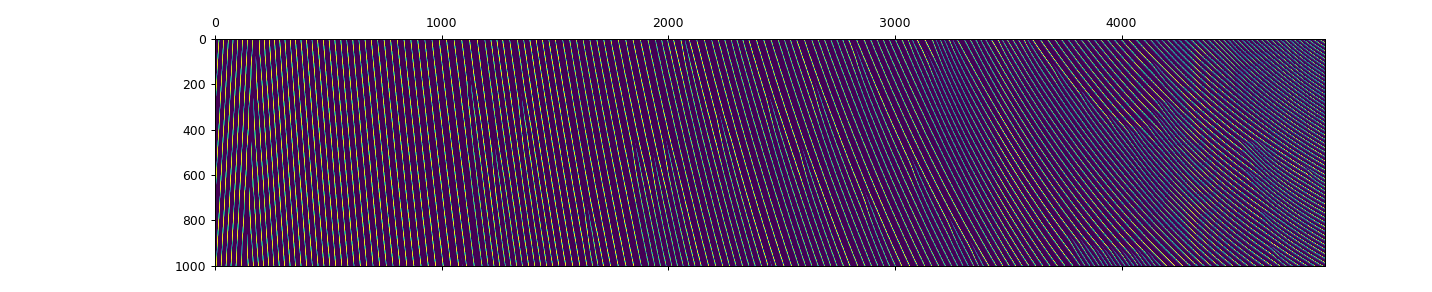

In [202]:
plt.matshow(results[-1000:, 50:-50]/np.max(results[-1000:, 50:-50], axis=0, keepdims=True))
plt.show()

<IPython.core.display.Javascript object>


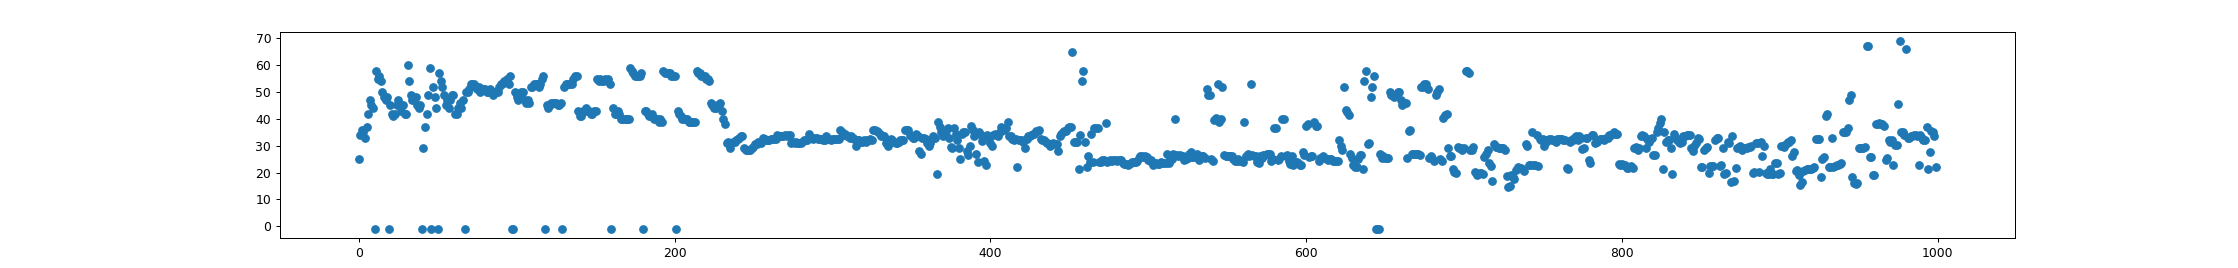

In [102]:
placeScales = compute_scales(torch.transpose(GCN.placeWeights, 0, 1).cpu().numpy()/np.max(torch.transpose(GCN.placeWeights, 0, 1).cpu().numpy(), axis=0, keepdims=True))
#activityScales = compute_scales(results[-1000:, 50:-50]/np.max(results[-1000:, 50:-50], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(1000), placeScales)
mod = 0.25
#for i in range(10):
#    ax.axhline(mod/0.89146)
#    mod *= np.sqrt(2)
plt.show()

In [ ]:
mask = np.zeros((GCN.numX, GCN.numY))

for i in range(0, GCN.numX, 1):
    for j in range(0, GCN.numY, 1):
        mask[i, j] = 1.

processedResults, flowVelocities, flowColors = get_data_flow_and_color_maps(results[1100:1150], GCN.numX, GCN.numY, mask, 1)
processedResults = processedResults.reshape(-1, GCN.numX, GCN.numY)
flowColors = flowColors.reshape(-1, GCN.numX, GCN.numY, 3)

In [ ]:
def createMovieWithFlow(data, colors, name):
    def update(num, data, a):
        results, flowColors = data
        a[0].set_data(results[num])
        a[1].set_data(flowColors[num])
        return a,

    fig, ax   = plt.subplots(1,2)

    a0  = ax[0].imshow(data[0], animated=True)
    a1  = ax[1].imshow(colors[0], animated=True)

    ani = animation.FuncAnimation(fig, update, data.shape[0] - 1, fargs=((data, colors,), (a0,a1)),
                                   interval=10, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
createMovieWithFlow(processedResults, flowColors,
                      "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\flowtest.mp4")

In [6]:
def createMovie(data, name, interval=10):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,
    
    fig, ax   = plt.subplots(1,1)

    a0  = ax.imshow(data[0], animated=True)
    ani = animation.FuncAnimation(fig, update_line, data.shape[0] - 1,
                                  fargs=(data, a0),
                                  interval=interval, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [15]:
np.min(results)

0.0

<IPython.core.display.Javascript object>


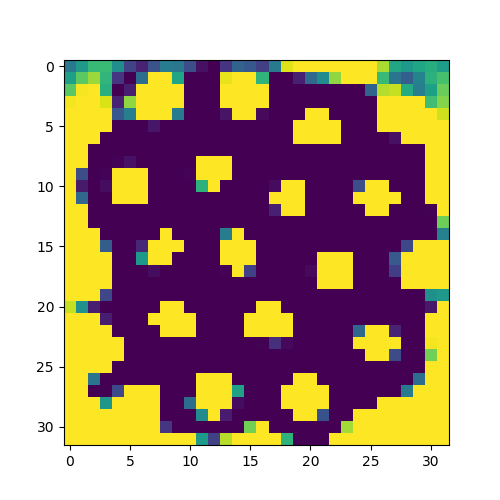

In [66]:
plt.rcParams['figure.figsize'] = [5, 5]
createMovie(results[-1000:], "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4", .01)

<video controls src="./test.mp4" />